In [1]:
!pip install xgboost lightgbm pandas seaborn scikit-learn optuna expetator cryptography

     |████████████████████████████████| 286kB 4.1MB/s 
     |████████████████████████████████| 2.9MB 6.9MB/s 
     |████████████████████████████████| 2.6MB 16.8MB/s 
     |████████████████████████████████| 163kB 42.1MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 481kB 20.0MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 112kB 42.0MB/s 
     |████████████████████████████████| 133kB 44.7MB/s 
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=de35a268ec59e63d644f0445f2dad2b4149e102767e4bb49d9b253a12f578f55
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=610817c37089185067b0f4756d3618bcbeb9df8b43813ff441fdd73bcfb1fdc2
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc

In [ ]:
!pip install imbalanced-learn

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/ML_DVFS/Modeling and evaluation'
os.chdir(PATH)

Mounted at /content/drive


In [3]:
from expetator.tools import read_experiment, show_heatmap, add_objectives
from expetator.tools import prune_vectors, mojitos_to_vectors, show_pct_distribution
from expetator.monitors import mojitos
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
import multiprocessing
#import optuna.integration.lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from random import sample 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def generate_en_features(df):
    df = df.copy()
    cols = set(df.columns)-{'metric','page_faults_min','expe','group','target'}
    for col in cols:
        for func in ['mean','std','min','max']:
            temp = df.groupby('expe')[col].agg([func]).rename({func:f"{col}_{func}"},axis=1)
            df = pd.merge(df,temp,on='expe',how='left')
        df[col+'_bin10'] = pd.cut(df[col], bins = 10, labels = False)
        df[col+'_bin100'] = pd.cut(df[col], bins = 100, labels = False)
        df[col+'_log'] = df[col].apply(lambda row: np.log(1+row))
        df[col+'log+1'] = (df[col]+1).transform(np.log)
        df[col+'log(x-min(x)+1)'] = (df[col]-df[col].min()+1) .transform(np.log)
    return df
def generate_aggregations(df):
    df = df.copy()
    for col in set(df.columns)-{'metric','expe','freq','group','target'}:
        for func in ['mean','std','min','max']:
          temp = vectors.groupby('expe')[col].agg([func]).rename({func:f"{col}_{func}"},axis=1)
          df = pd.merge(df,temp,on='expe',how='left')
    return df
def outlierdrop(df,factor):
    for col in set(df.columns) - {'metric','expe','freq','group','target'}:
        upper_lim = df[col].mean () + df[col].std () * factor
        lower_lim = df[col].mean () - df[col].std () * factor
        df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]
    return df
def outlierfill(df):
    for column in set(df.columns) - {'metric','expe','freq','group','target'}:
        upper_lim = df[column].quantile(.95)
        lower_lim = df[column].quantile(0.05)
        df.loc[(df[column] > upper_lim),column] = upper_lim
        df.loc[(df[column] < lower_lim),column] = lower_lim
    return df
all_knowledge = pd.read_csv("../csvs/knowledge_allmetrics.csv")
all_vectors = pd.read_csv("../csvs/vectors_allmetrics.csv")
all_vectors['typedata'] = 0

all_knowledge_old = pd.read_csv("../csvs/old/knowledge_allmetrics.csv")
all_vectors_old = pd.read_csv("../csvs/old/vectors_allmetrics.csv")
all_knowledge_old['expe'] = all_knowledge_old['expe'] + all_knowledge.expe.values[-1] + 1
all_vectors_old['typedata'] = 1

all_knowledge = pd.concat([all_knowledge, all_knowledge_old],ignore_index=True)
all_vectors = pd.concat([all_vectors, all_vectors_old],ignore_index=True)

# merge knowlage to vectors => data for training 
all_vectors['expe'] = all_knowledge.expe
all_vectors['target'] = all_knowledge['target']

ignore_columns = ['irxp', 'irxb','itxp', 'itxb', 'core0','core1','bpf_output',
                 'alignment_faults','page_faults_maj','dummy','emulation_faults','nice',
                 'irq','steal','guest','guest_nice']
all_vectors = all_vectors.loc[:,~ all_vectors.columns.isin(ignore_columns)]
all_vectors_outlier = outlierfill(all_vectors)
vectorbin = generate_en_features(all_vectors_outlier)
vectors = prune_vectors(vectorbin)


ignore_columns = ['typedata','expe','group','target','Kfold', #'guest', 'guest_nice', 'irq',
                  #'steal','nice','emulation_faults','irxp', 'irxb', 
                  #'itxp', 'itxb', 'core0','core1','iowait','softirq','txp',
                 ]

# convert categories to numerical
metric_mapping = {
    "energy":0,
    "duration":1,
    "etp":2
}
#vectors['metric'] = all_knowledge['metric'].map(metric_mapping)
vectors = vectors[all_knowledge['metric'] == 'energy']
labels = [1200000,
     1300000,
     1400000,
     1500000,
     1600000,
     1700000,
     1800000,
     1900000,
     2000000,
     2100000,
     2200000,
     2300000,
     2400000]
vectors['target'] = vectors.target.apply(lambda row: labels.index(row))

#split dataset to train, test: 0.8:0.2. Note that split base on expe
testidx = []
exps = list(set(vectors[vectors['typedata'] == 1].expe))
testidx.extend(sample(exps, int(0.2*len(exps))))

exps = list(set(vectors[vectors['typedata'] == 0].expe))
testidx.extend(sample(exps, int(0.2*len(exps))))

train = vectors[~vectors.expe.isin(testidx)].reset_index(drop=True)
test = vectors[vectors.expe.isin(testidx)].reset_index(drop=True)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [9]:
def lgb_f1mse_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat) + 2*mean_squared_error(y_true,y_hat), True
metric_list=['merror']
earlyStop=30
def optimize(trial):
    boosting_list = ['gbdt','goss']
    objective_list_reg = ['huber', 'gamma', 'fair', 'tweedie']
    objective_list_class = ['multiclass','multiclassova']
    param={
      'num_class':13,
      'boosting':trial.suggest_categorical('boosting',boosting_list),
      'num_leaves':trial.suggest_int('num_leaves', 2, 2**11),
      'max_depth':trial.suggest_int('max_depth', 2, 25),
      'max_bin': trial.suggest_int('max_bin', 32, 255),      
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 256),
      'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
      'min_gain_to_split' : trial.suggest_discrete_uniform('min_gain_to_split', 0.1, 5, 0.01),      
      'lambda_l1':trial.suggest_loguniform('lamda_l1',1e-8,10),
      'lambda_l2':trial.suggest_loguniform('lamda_l2',1e-8,10),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
      'metric':trial.suggest_categorical('metric', ['multi_logloss','multi_error']),#'multi_logloss','multi_error'
      'objective':trial.suggest_categorical('objective',objective_list_class),
      'bagging_fraction':trial.suggest_discrete_uniform('bagging_fraction',0.5, 1, 0.01),
      'feature_fraction':trial.suggest_discrete_uniform('feature_fraction',0.5, 1, 0.01),
      'num_threads': multiprocessing.cpu_count(),
      'verbose':-1,
      #'is_unbalance':'true',
      #'class_weight':class_weight_dict
        
    }
    
    
    accuracies = []
    skf = GroupKFold(n_splits=5)
    train['group'] = train.apply(lambda row: str(row['expe'])+str(row['typedata']),axis = 1)
    test_pro = []
    for i, (train_index, test_index) in enumerate(skf.split(train, train.target, groups = train['group'])):
        xtrain_fold = train.loc[train_index, ~train.columns.isin(ignore_columns)]
        ytrain_fold = train.loc[train_index,'target']
        X_val_fold = train.loc[test_index, ~train.columns.isin(ignore_columns)]
        y_val_fold = train.loc[test_index,'target']
        

        df_Ytrain = ytrain_fold.reset_index(drop=True)
        df_Yval = y_val_fold.reset_index(drop=True)

        sc = StandardScaler()
        df_train = sc.fit_transform(xtrain_fold)
        df_val = sc.transform(X_val_fold)
    
        #over = SMOTE()
        #under = RandomUnderSampler()
        #steps = [('u', under)]#('o', over), 
        #pipeline = Pipeline(steps=steps)
        #xthang, ythang = pipeline.fit_resample(df_train, df_Ytrain)

        #df_Xtrain_sc = pd.DataFrame(xthang,columns = xtrain_fold.columns)
        df_Xtrain_sc = pd.DataFrame(df_train,columns = xtrain_fold.columns)
        df_Xval_sc = pd.DataFrame(df_val,columns = X_val_fold.columns)

        
        dtrain = lgb.Dataset(df_Xtrain_sc,label=df_Ytrain)
        dval = lgb.Dataset(df_Xval_sc,label=df_Yval)
        watchlist = [dtrain,dval]
        lgbmPruningCallback = optuna.integration.LightGBMPruningCallback(trial, 'rmse', valid_name='valid_2')

        model = lgb.train(param,train_set=dtrain,num_boost_round=1000,valid_sets=watchlist,verbose_eval=-1,early_stopping_rounds=earlyStop)#callbacks=[lgbmPruningCallback]
        #bst = lgb.train(param, dtrain)
        #preds = bst.predict(dval)
        pred_val=model.predict(df_Xval_sc,num_iteration=model.best_iteration)
        
        df_Yval = y_val_fold.reset_index(drop=True)
        preds = np.argmax(pred_val,axis = 1)
        accuracy = accuracy_score(df_Yval, preds)
        print(f"                                                                                  FOLD{i}-val acc: {(accuracy * 100.0)}", end=' ')
        
        accuracies.append(accuracy)
        
        X_test = test.loc[:, ~test.columns.isin(ignore_columns)]
        df_Xtest = sc.transform(X_test)
        df_Xtest_sc = pd.DataFrame(df_Xtest,columns = X_test.columns)
        y_test = test.target.reset_index(drop=True)
        pred_val=model.predict(df_Xtest_sc,num_iteration=model.best_iteration)
        
        #dtest = lgb.Dataset(df_Xtest_sc,label=y_test)
        test_pro.append(pred_val)
        #preds = bst.predict(dtest)
        preds = np.argmax(pred_val,axis = 1)
        accuracy = accuracy_score(y_test, preds)
        print(f" FOLD{i}-test acc: {(accuracy * 100.0)}")
    test_pro_mean = np.mean(test_pro,axis=0)
    preds = np.argmax(test_pro_mean,axis = 1)
    accuracy = accuracy_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    mse_fre = mean_squared_error([labels[i] for i in y_test], [labels[i] for i in preds])
    print(f"=====================> TTA on test acc: {(accuracy * 100.0)}, mse: {mse} ~ {mse_fre}")
    
    if accuracy > 0.72:
      print(classification_report(y_test, preds))
      cfm = confusion_matrix(y_test, preds, labels = range(0,13))
      cm = cfm
      cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
      tmplabel = [i//100000 for i in labels]
      annot = np.empty_like(cfm).astype(str)
      nrows, ncols = cfm.shape
      for i in range(nrows):
          for j in range(ncols):
              c = cfm[i, j]*100
              if c == 0:
                  annot[i, j] = ''
              else:
                annot[i, j] = '%.1f%%\n%d' % (c,cm[i, j])
      plt.figure(figsize=(12,10))
      ax = sns.heatmap(cfm, annot=annot, fmt='',cmap="YlGnBu")
      ax.set_xticklabels(tmplabel)
      ax.set_yticklabels(tmplabel)
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.show()       
        
    return -1.0*np.mean(accuracies)

[I 2021-01-17 09:22:21,938] A new study created in memory with name: no-name-ccd3b6f5-3a6d-4292-9e58-9b52d859cd1f


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[40]	training's multi_logloss: 0.311446	valid_1's multi_logloss: 1.12992
                                                                                  FOLD0-val acc: 71.8639053254438  FOLD0-test acc: 69.287236561686
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[36]	training's multi_logloss: 0.337549	valid_1's multi_logloss: 1.12269
                                                                                  FOLD1-val acc: 71.61921708185054  FOLD1-test acc: 70.42386928723656
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[32]	training's multi_logloss: 0.370396	valid_1's multi_logloss: 1.09344
                                                                                  FOLD2-val acc: 73.36892052194544  FOLD2-test acc: 70.85010655931802
Training until validation scores don't impr

[I 2021-01-17 09:23:03,785] Trial 0 finished with value: -0.7239769209711723 and parameters: {'boosting': 'goss', 'num_leaves': 1009, 'max_depth': 21, 'max_bin': 222, 'min_data_in_leaf': 30, 'min_data_in_bin': 151, 'min_gain_to_split': 2.98, 'lamda_l1': 1.154521919603102e-05, 'lamda_l2': 0.00018390264041300426, 'learning_rate': 0.06675479783459823, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.86, 'feature_fraction': 0.69}. Best is trial 0 with value: -0.7239769209711723.


                                                                                  FOLD4-val acc: 73.87307236061685  FOLD4-test acc: 69.73715368221643
=====================> TTA on test acc: 71.53682216433815, mse: 3.6760596732180915 ~ 36760596732.180916
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[21]	training's multi_logloss: 0.287841	valid_1's multi_logloss: 0.982784
                                                                                  FOLD0-val acc: 70.02958579881657  FOLD0-test acc: 67.62964717025811
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[24]	training's multi_logloss: 0.273239	valid_1's multi_logloss: 0.913752
                                                                                  FOLD1-val acc: 71.23368920521945  FOLD1-test acc: 68.83731944115557
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[21]	tr

[I 2021-01-17 09:23:26,630] Trial 1 finished with value: -0.7039381751563519 and parameters: {'boosting': 'goss', 'num_leaves': 277, 'max_depth': 7, 'max_bin': 61, 'min_data_in_leaf': 70, 'min_data_in_bin': 10, 'min_gain_to_split': 3.6300000000000003, 'lamda_l1': 1.0676168016861324e-05, 'lamda_l2': 5.416489093659723e-05, 'learning_rate': 0.4277606061316545, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.78}. Best is trial 0 with value: -0.7239769209711723.


Early stopping, best iteration is:
[25]	training's multi_logloss: 0.281482	valid_1's multi_logloss: 0.903906
                                                                                  FOLD4-val acc: 70.75919335705812  FOLD4-test acc: 66.72981292919725
=====================> TTA on test acc: 69.97395216670613, mse: 3.874733601704949 ~ 38747336017.04949
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.402297	valid_1's multi_logloss: 0.997952
                                                                                  FOLD0-val acc: 71.53846153846153  FOLD0-test acc: 69.71347383376745
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.377816	valid_1's multi_logloss: 0.988591
                                                                                  FOLD1-val acc: 71.44128113879003  FOLD1-test acc: 69.3582761070

[I 2021-01-17 09:25:08,900] Trial 2 finished with value: -0.7222584177388448 and parameters: {'boosting': 'gbdt', 'num_leaves': 465, 'max_depth': 12, 'max_bin': 151, 'min_data_in_leaf': 221, 'min_data_in_bin': 87, 'min_gain_to_split': 4.739999999999999, 'lamda_l1': 0.4347471932855257, 'lamda_l2': 2.385935590843747e-08, 'learning_rate': 0.03746192098316424, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.59, 'feature_fraction': 0.8300000000000001}. Best is trial 0 with value: -0.7239769209711723.


 FOLD4-test acc: 68.76627989580867
=====================> TTA on test acc: 70.4712289841345, mse: 3.8792327729102536 ~ 38792327729.10253
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[951]	training's multi_logloss: 0.311064	valid_1's multi_logloss: 0.863847
                                                                                  FOLD0-val acc: 71.03550295857988  FOLD0-test acc: 70.37650959033861
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.29729	valid_1's multi_logloss: 0.865004
                                                                                  FOLD1-val acc: 72.21233689205219  FOLD1-test acc: 69.45299550082879
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[935]	training's multi_logloss: 0.312454	valid_1's multi_logloss: 0.871071
                                  

[I 2021-01-17 09:31:53,398] Trial 3 finished with value: -0.7208373167119403 and parameters: {'boosting': 'goss', 'num_leaves': 1573, 'max_depth': 23, 'max_bin': 179, 'min_data_in_leaf': 238, 'min_data_in_bin': 63, 'min_gain_to_split': 1.86, 'lamda_l1': 1.3400102175381028, 'lamda_l2': 0.0003702783173471306, 'learning_rate': 0.013386752811129842, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.78, 'feature_fraction': 0.7}. Best is trial 0 with value: -0.7239769209711723.


 FOLD4-test acc: 68.31636277527824
=====================> TTA on test acc: 70.35282974188965, mse: 3.8979398531849396 ~ 38979398531.849396
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.224279	valid_1's multi_logloss: 0.878865
                                                                                  FOLD0-val acc: 70.71005917159763  FOLD0-test acc: 70.82642671086904
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[250]	training's multi_logloss: 0.201476	valid_1's multi_logloss: 0.87509
                                                                                  FOLD1-val acc: 71.94543297746144  FOLD1-test acc: 69.71347383376745
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[189]	training's multi_logloss: 0.217614	valid_1's multi_logloss: 0.873962
                                              

[I 2021-01-17 09:33:47,669] Trial 4 finished with value: -0.7226182203598026 and parameters: {'boosting': 'goss', 'num_leaves': 206, 'max_depth': 16, 'max_bin': 187, 'min_data_in_leaf': 61, 'min_data_in_bin': 71, 'min_gain_to_split': 2.71, 'lamda_l1': 4.137384360118605e-06, 'lamda_l2': 0.8573022210668029, 'learning_rate': 0.053380473453429854, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.56, 'feature_fraction': 0.95}. Best is trial 0 with value: -0.7239769209711723.


 FOLD4-test acc: 69.14515747099217
=====================> TTA on test acc: 70.56594837793038, mse: 3.747099218565001 ~ 37470992185.65001
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[140]	training's multi_error: 0.100311	valid_1's multi_error: 0.288757
                                                                                  FOLD0-val acc: 71.12426035502959  FOLD0-test acc: 69.42931565237981
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[156]	training's multi_error: 0.0880261	valid_1's multi_error: 0.278766
                                                                                  FOLD1-val acc: 72.12336892052194  FOLD1-test acc: 71.27634383139949
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[104]	training's multi_error: 0.116034	valid_1's multi_error: 0.261566
                                                          

[I 2021-01-17 09:35:07,150] Trial 5 finished with value: -0.7191761600932146 and parameters: {'boosting': 'goss', 'num_leaves': 1691, 'max_depth': 21, 'max_bin': 99, 'min_data_in_leaf': 111, 'min_data_in_bin': 51, 'min_gain_to_split': 2.94, 'lamda_l1': 0.05098730257955937, 'lamda_l2': 9.786243350349481e-08, 'learning_rate': 0.02508265010725277, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.55, 'feature_fraction': 0.6799999999999999}. Best is trial 0 with value: -0.7239769209711723.


                                                                                  FOLD4-val acc: 72.3606168446026  FOLD4-test acc: 70.13971110584892
=====================> TTA on test acc: 71.51314231588918, mse: 3.867866445654748 ~ 38678664456.54748
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[5]	training's multi_logloss: 0.214613	valid_1's multi_logloss: 1.18655
                                                                                  FOLD0-val acc: 68.13609467455622  FOLD0-test acc: 67.3218091404215
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[3]	training's multi_logloss: 0.35264	valid_1's multi_logloss: 1.17741
                                                                                  FOLD1-val acc: 65.36180308422301  FOLD1-test acc: 65.49846080985081
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[5]	training's m

[I 2021-01-17 09:35:30,098] Trial 6 finished with value: -0.6817051668105596 and parameters: {'boosting': 'gbdt', 'num_leaves': 706, 'max_depth': 13, 'max_bin': 112, 'min_data_in_leaf': 15, 'min_data_in_bin': 112, 'min_gain_to_split': 0.77, 'lamda_l1': 0.018276651624703436, 'lamda_l2': 3.480982907187415e-07, 'learning_rate': 0.30539462920063437, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.75, 'feature_fraction': 0.58}. Best is trial 0 with value: -0.7239769209711723.


Early stopping, best iteration is:
[5]	training's multi_logloss: 0.221124	valid_1's multi_logloss: 1.11521
                                                                                  FOLD4-val acc: 69.42467378410439  FOLD4-test acc: 66.11413686952403
=====================> TTA on test acc: 70.68434762017523, mse: 3.874733601704949 ~ 38747336017.04949
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[26]	training's multi_error: 0.0652432	valid_1's multi_error: 0.286391
                                                                                  FOLD0-val acc: 71.36094674556213  FOLD0-test acc: 70.9448259531139
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[79]	training's multi_error: 0.0328245	valid_1's multi_error: 0.274911
                                                                                  FOLD1-val acc: 72.50889679715303  FOLD1-test acc: 70.28179019654274
Traini

[I 2021-01-17 09:36:27,524] Trial 7 finished with value: -0.7290208258754658 and parameters: {'boosting': 'gbdt', 'num_leaves': 1805, 'max_depth': 7, 'max_bin': 251, 'min_data_in_leaf': 60, 'min_data_in_bin': 30, 'min_gain_to_split': 1.28, 'lamda_l1': 1.6185215920968407e-06, 'lamda_l2': 0.0001554128748781998, 'learning_rate': 0.12332127582230748, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.61, 'feature_fraction': 0.58}. Best is trial 7 with value: -0.7290208258754658.


                                                                                  FOLD4-val acc: 74.55516014234875  FOLD4-test acc: 69.71347383376745
=====================> TTA on test acc: 71.93937958797065, mse: 3.5702107506511958 ~ 35702107506.511955
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[17]	training's multi_error: 0.0707295	valid_1's multi_error: 0.294675
                                                                                  FOLD0-val acc: 70.53254437869822  FOLD0-test acc: 68.43476201752308
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[26]	training's multi_error: 0.064834	valid_1's multi_error: 0.279953
                                                                                  FOLD1-val acc: 72.00474495848161  FOLD1-test acc: 69.0504380771963
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[18]	training's

[I 2021-01-17 09:36:49,304] Trial 8 finished with value: -0.7181113521025921 and parameters: {'boosting': 'gbdt', 'num_leaves': 587, 'max_depth': 7, 'max_bin': 169, 'min_data_in_leaf': 41, 'min_data_in_bin': 233, 'min_gain_to_split': 4.16, 'lamda_l1': 1.1215364941515558, 'lamda_l2': 0.00041892570967119166, 'learning_rate': 0.20580046718174264, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.89, 'feature_fraction': 0.73}. Best is trial 7 with value: -0.7290208258754658.


Early stopping, best iteration is:
[9]	training's multi_error: 0.0959544	valid_1's multi_error: 0.275208
                                                                                  FOLD4-val acc: 72.47924080664293  FOLD4-test acc: 68.9793985318494
=====================> TTA on test acc: 70.35282974188965, mse: 3.857684110821691 ~ 38576841108.2169
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[194]	training's multi_error: 0.0409994	valid_1's multi_error: 0.270414
                                                                                  FOLD0-val acc: 72.9585798816568  FOLD0-test acc: 71.46578261899124
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[150]	training's multi_error: 0.0574244	valid_1's multi_error: 0.272242
                                                                                  FOLD1-val acc: 72.77580071174377  FOLD1-test acc: 70.80274686242008
Training

[I 2021-01-17 09:39:32,961] Trial 9 finished with value: -0.7319195322425545 and parameters: {'boosting': 'gbdt', 'num_leaves': 715, 'max_depth': 9, 'max_bin': 105, 'min_data_in_leaf': 195, 'min_data_in_bin': 80, 'min_gain_to_split': 0.53, 'lamda_l1': 0.0071430386862228095, 'lamda_l2': 2.3658834075373204e-08, 'learning_rate': 0.024873871853528615, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.73, 'feature_fraction': 0.51}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 69.5240350461757
=====================> TTA on test acc: 71.4894624674402, mse: 3.7068434762017524 ~ 37068434762.017525
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[807]	training's multi_error: 0.288775	valid_1's multi_error: 0.321893
                                                                                  FOLD0-val acc: 67.81065088757397  FOLD0-test acc: 68.95571868340042
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[542]	training's multi_error: 0.305646	valid_1's multi_error: 0.335706
                                                                                  FOLD1-val acc: 66.429418742586  FOLD1-test acc: 67.91380535164575
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[444]	training's multi_error: 0.319576	valid_1's multi_error: 0.325919
                                                             

[I 2021-01-17 09:43:01,982] Trial 10 finished with value: -0.6736995935900945 and parameters: {'boosting': 'gbdt', 'num_leaves': 1251, 'max_depth': 2, 'max_bin': 44, 'min_data_in_leaf': 179, 'min_data_in_bin': 170, 'min_gain_to_split': 0.15000000000000002, 'lamda_l1': 0.001345488796128976, 'lamda_l2': 4.166177472053045, 'learning_rate': 0.00564262211133275, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.99, 'feature_fraction': 0.52}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 68.90835898650248
=====================> TTA on test acc: 68.60052095666587, mse: 6.884679138053516 ~ 68846791380.53517
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	training's multi_error: 0.0650208	valid_1's multi_error: 0.27929
                                                                                  FOLD0-val acc: 72.07100591715975  FOLD0-test acc: 70.42386928723656
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[68]	training's multi_error: 0.0496443	valid_1's multi_error: 0.273132
                                                                                  FOLD1-val acc: 72.68683274021353  FOLD1-test acc: 70.66066777172625
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[36]	training's multi_error: 0.106328	valid_1's multi_error: 0.262456
                                                             

[I 2021-01-17 09:44:03,907] Trial 11 finished with value: -0.727178785262552 and parameters: {'boosting': 'gbdt', 'num_leaves': 1929, 'max_depth': 6, 'max_bin': 240, 'min_data_in_leaf': 168, 'min_data_in_bin': 6, 'min_gain_to_split': 1.11, 'lamda_l1': 4.321952002918951e-08, 'lamda_l2': 0.02554510364041177, 'learning_rate': 0.11825533578569355, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.65, 'feature_fraction': 0.5}. Best is trial 9 with value: -0.7319195322425545.


                                                                                  FOLD4-val acc: 74.05100830367735  FOLD4-test acc: 69.73715368221643
=====================> TTA on test acc: 71.27634383139949, mse: 3.8565001183992424 ~ 38565001183.992424
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[258]	training's multi_error: 0.234282	valid_1's multi_error: 0.297041
                                                                                  FOLD0-val acc: 70.29585798816568  FOLD0-test acc: 70.09235140895098
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[111]	training's multi_error: 0.277564	valid_1's multi_error: 0.330368
                                                                                  FOLD1-val acc: 66.96322657176749  FOLD1-test acc: 69.38195595548189
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[117]	trainin

[I 2021-01-17 09:46:15,933] Trial 12 finished with value: -0.7004375048256789 and parameters: {'boosting': 'gbdt', 'num_leaves': 1119, 'max_depth': 3, 'max_bin': 106, 'min_data_in_leaf': 109, 'min_data_in_bin': 30, 'min_gain_to_split': 1.56, 'lamda_l1': 1.554614300187323e-08, 'lamda_l2': 6.078729659526443e-06, 'learning_rate': 0.013179234975904059, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.66, 'feature_fraction': 0.58}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 70.61330807482832
=====================> TTA on test acc: 71.30002367984845, mse: 4.6552214065829975 ~ 46552214065.82998
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[51]	training's multi_error: 0.0418891	valid_1's multi_error: 0.283136
                                                                                  FOLD0-val acc: 71.68639053254438  FOLD0-test acc: 71.08690504380772
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[32]	training's multi_error: 0.0751334	valid_1's multi_error: 0.273725
                                                                                  FOLD1-val acc: 72.62752075919336  FOLD1-test acc: 71.01586549846081
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[69]	training's multi_error: 0.0228216	valid_1's multi_error: 0.261862
                                                          

[I 2021-01-17 09:47:13,472] Trial 13 finished with value: -0.7237405153474138 and parameters: {'boosting': 'gbdt', 'num_leaves': 892, 'max_depth': 10, 'max_bin': 76, 'min_data_in_leaf': 164, 'min_data_in_bin': 109, 'min_gain_to_split': 0.41000000000000003, 'lamda_l1': 0.00022338515448155926, 'lamda_l2': 0.03413358277029316, 'learning_rate': 0.11485430752704945, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.7, 'feature_fraction': 0.59}. Best is trial 9 with value: -0.7319195322425545.


                                                                                  FOLD4-val acc: 74.02135231316726  FOLD4-test acc: 69.50035519772673
=====================> TTA on test acc: 71.56050201278713, mse: 3.7390480700923514 ~ 37390480700.923515
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[170]	training's multi_error: 0.0850386	valid_1's multi_error: 0.276331
                                                                                  FOLD0-val acc: 72.36686390532545  FOLD0-test acc: 71.30002367984845
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[145]	training's multi_error: 0.0983254	valid_1's multi_error: 0.286773
                                                                                  FOLD1-val acc: 71.3226571767497  FOLD1-test acc: 71.4894624674402
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[242]	trainin

[I 2021-01-17 09:50:01,220] Trial 14 finished with value: -0.725160774073996 and parameters: {'boosting': 'gbdt', 'num_leaves': 1325, 'max_depth': 17, 'max_bin': 255, 'min_data_in_leaf': 212, 'min_data_in_bin': 34, 'min_gain_to_split': 1.9300000000000002, 'lamda_l1': 1.7146966198421827e-07, 'lamda_l2': 2.2647539937256677e-06, 'learning_rate': 0.022232057530212734, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.51, 'feature_fraction': 0.5}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 70.18707080274686
=====================> TTA on test acc: 70.92114610466493, mse: 4.091641013497513 ~ 40916410134.975136
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[68]	training's multi_error: 0.021723	valid_1's multi_error: 0.271598
                                                                                  FOLD0-val acc: 72.84023668639054  FOLD0-test acc: 70.42386928723656
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[31]	training's multi_error: 0.0471992	valid_1's multi_error: 0.271945
                                                                                  FOLD1-val acc: 72.80545670225386  FOLD1-test acc: 70.18707080274686
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[29]	training's multi_error: 0.0482365	valid_1's multi_error: 0.262159
                                                           

[I 2021-01-17 09:50:48,826] Trial 15 finished with value: -0.7265820154842876 and parameters: {'boosting': 'gbdt', 'num_leaves': 1953, 'max_depth': 10, 'max_bin': 130, 'min_data_in_leaf': 134, 'min_data_in_bin': 193, 'min_gain_to_split': 1.11, 'lamda_l1': 0.0007099449603735498, 'lamda_l2': 1.849004980754694e-08, 'learning_rate': 0.11601456420378128, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.62, 'feature_fraction': 0.61}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 68.64788065356382
=====================> TTA on test acc: 71.06322519535875, mse: 3.6649301444470757 ~ 36649301444.47076
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[174]	training's multi_error: 0.256005	valid_1's multi_error: 0.315385
                                                                                  FOLD0-val acc: 68.46153846153847  FOLD0-test acc: 69.14515747099217
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[92]	training's multi_error: 0.279861	valid_1's multi_error: 0.323843
                                                                                  FOLD1-val acc: 67.61565836298932  FOLD1-test acc: 69.02675822874733
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[524]	training's multi_error: 0.167976	valid_1's multi_error: 0.272539
                                                           

[I 2021-01-17 09:54:52,202] Trial 16 finished with value: -0.6949895063418196 and parameters: {'boosting': 'gbdt', 'num_leaves': 20, 'max_depth': 4, 'max_bin': 209, 'min_data_in_leaf': 253, 'min_data_in_bin': 94, 'min_gain_to_split': 0.12000000000000001, 'lamda_l1': 8.917877241462943e-07, 'lamda_l2': 0.006571592565283862, 'learning_rate': 0.0070003305217351194, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.71, 'feature_fraction': 0.89}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 70.63698792327729
=====================> TTA on test acc: 70.82642671086904, mse: 4.919251716789012 ~ 49192517167.89013
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[117]	training's multi_error: 0.0546412	valid_1's multi_error: 0.275444
                                                                                  FOLD0-val acc: 72.45562130177515  FOLD0-test acc: 70.30547004499171
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[34]	training's multi_error: 0.0794309	valid_1's multi_error: 0.281139
                                                                                  FOLD1-val acc: 71.88612099644128  FOLD1-test acc: 71.15794458915462
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	training's multi_error: 0.0649822	valid_1's multi_error: 0.254152
                                                          

[I 2021-01-17 09:55:46,648] Trial 17 finished with value: -0.7284225118799441 and parameters: {'boosting': 'gbdt', 'num_leaves': 818, 'max_depth': 9, 'max_bin': 139, 'min_data_in_leaf': 82, 'min_data_in_bin': 135, 'min_gain_to_split': 2.18, 'lamda_l1': 0.00012237069489370744, 'lamda_l2': 9.14692161700951e-06, 'learning_rate': 0.07272733295594898, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.76, 'feature_fraction': 0.63}. Best is trial 9 with value: -0.7319195322425545.


                                                                                  FOLD4-val acc: 74.61447212336893  FOLD4-test acc: 69.16883731944115
=====================> TTA on test acc: 70.96850580156287, mse: 3.709448259531139 ~ 37094482595.31139
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[30]	training's multi_error: 0.0567912	valid_1's multi_error: 0.288166
                                                                                  FOLD0-val acc: 71.18343195266273  FOLD0-test acc: 69.71347383376745
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[39]	training's multi_error: 0.0481624	valid_1's multi_error: 0.273132
                                                                                  FOLD1-val acc: 72.68683274021353  FOLD1-test acc: 69.54771489462468
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[56]	training's

[I 2021-01-17 09:56:18,372] Trial 18 finished with value: -0.7208366147950052 and parameters: {'boosting': 'gbdt', 'num_leaves': 1533, 'max_depth': 16, 'max_bin': 76, 'min_data_in_leaf': 200, 'min_data_in_bin': 40, 'min_gain_to_split': 1.26, 'lamda_l1': 0.00943052901848191, 'lamda_l2': 5.302608701160383e-07, 'learning_rate': 0.18873768754405476, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.81, 'feature_fraction': 0.55}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 67.5586076249112
=====================> TTA on test acc: 70.92114610466493, mse: 3.7802510063935593 ~ 37802510063.93559
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[107]	training's multi_error: 0.138716	valid_1's multi_error: 0.284911
                                                                                  FOLD0-val acc: 71.50887573964498  FOLD0-test acc: 70.30547004499171
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[122]	training's multi_error: 0.121888	valid_1's multi_error: 0.269276
                                                                                  FOLD1-val acc: 73.0723606168446  FOLD1-test acc: 71.20530428605257
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[229]	training's multi_error: 0.0503853	valid_1's multi_error: 0.255338
                                                           

[I 2021-01-17 09:58:23,507] Trial 19 finished with value: -0.7265290207556838 and parameters: {'boosting': 'gbdt', 'num_leaves': 465, 'max_depth': 5, 'max_bin': 88, 'min_data_in_leaf': 136, 'min_data_in_bin': 77, 'min_gain_to_split': 0.58, 'lamda_l1': 5.490949062135036e-05, 'lamda_l2': 0.41777439965801644, 'learning_rate': 0.027154986296789804, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.6799999999999999, 'feature_fraction': 0.65}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 70.82642671086904
=====================> TTA on test acc: 71.655221406583, mse: 3.7295761307127635 ~ 37295761307.12763
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[214]	training's multi_error: 0.0961595	valid_1's multi_error: 0.283432
                                                                                  FOLD0-val acc: 71.65680473372781  FOLD0-test acc: 70.49490883258346
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[231]	training's multi_error: 0.0855809	valid_1's multi_error: 0.277877
                                                                                  FOLD1-val acc: 72.21233689205219  FOLD1-test acc: 70.9448259531139
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[267]	training's multi_error: 0.0758743	valid_1's multi_error: 0.253855
                                                          

[I 2021-01-17 10:01:04,497] Trial 20 finished with value: -0.7254607031803857 and parameters: {'boosting': 'gbdt', 'num_leaves': 2041, 'max_depth': 9, 'max_bin': 35, 'min_data_in_leaf': 111, 'min_data_in_bin': 16, 'min_gain_to_split': 0.83, 'lamda_l1': 0.0031029253559207177, 'lamda_l2': 0.00308754972636317, 'learning_rate': 0.011460559646066307, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.51, 'feature_fraction': 0.53}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 70.13971110584892
=====================> TTA on test acc: 71.22898413450154, mse: 3.886573525929434 ~ 38865735259.29434
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[67]	training's multi_error: 0.0606465	valid_1's multi_error: 0.286095
                                                                                  FOLD0-val acc: 71.39053254437869  FOLD0-test acc: 70.28179019654274
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[44]	training's multi_error: 0.0711322	valid_1's multi_error: 0.282622
                                                                                  FOLD1-val acc: 71.73784104389087  FOLD1-test acc: 71.15794458915462
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[39]	training's multi_error: 0.0791346	valid_1's multi_error: 0.270463
                                                           

[I 2021-01-17 10:01:59,699] Trial 21 finished with value: -0.7211915039974169 and parameters: {'boosting': 'gbdt', 'num_leaves': 836, 'max_depth': 9, 'max_bin': 138, 'min_data_in_leaf': 84, 'min_data_in_bin': 131, 'min_gain_to_split': 2.06, 'lamda_l1': 5.611489869839397e-05, 'lamda_l2': 1.7428490530689476e-05, 'learning_rate': 0.06375655989054907, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.74, 'feature_fraction': 0.64}. Best is trial 9 with value: -0.7319195322425545.


                                                                                  FOLD4-val acc: 73.54685646500593  FOLD4-test acc: 69.12147762254321
=====================> TTA on test acc: 71.22898413450154, mse: 3.7475728155339807 ~ 37475728155.339806
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[11]	training's multi_error: 0.0219454	valid_1's multi_error: 0.309467
                                                                                  FOLD0-val acc: 69.05325443786982  FOLD0-test acc: 69.68979398531849
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[11]	training's multi_error: 0.0233402	valid_1's multi_error: 0.313464
                                                                                  FOLD1-val acc: 68.65361803084224  FOLD1-test acc: 68.95571868340042
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[13]	training

[I 2021-01-17 10:02:33,634] Trial 22 finished with value: -0.7037648718650635 and parameters: {'boosting': 'gbdt', 'num_leaves': 771, 'max_depth': 12, 'max_bin': 156, 'min_data_in_leaf': 1, 'min_data_in_bin': 134, 'min_gain_to_split': 2.46, 'lamda_l1': 4.867921237162016e-07, 'lamda_l2': 1.7970892559527941e-06, 'learning_rate': 0.08388083807524513, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.63}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 69.40563580393085
=====================> TTA on test acc: 71.20530428605257, mse: 3.7698318730760123 ~ 37698318730.760124
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[103]	training's multi_error: 0.0703588	valid_1's multi_error: 0.274556
                                                                                  FOLD0-val acc: 72.54437869822485  FOLD0-test acc: 70.2344304996448
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[75]	training's multi_error: 0.0783936	valid_1's multi_error: 0.279359
                                                                                  FOLD1-val acc: 72.06405693950177  FOLD1-test acc: 70.49490883258346
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[56]	training's multi_error: 0.10003	valid_1's multi_error: 0.263049
                                                           

[I 2021-01-17 10:03:31,577] Trial 23 finished with value: -0.7246854359255126 and parameters: {'boosting': 'gbdt', 'num_leaves': 1014, 'max_depth': 8, 'max_bin': 130, 'min_data_in_leaf': 86, 'min_data_in_bin': 187, 'min_gain_to_split': 2.3000000000000003, 'lamda_l1': 0.10930434198930794, 'lamda_l2': 3.927916203246955e-05, 'learning_rate': 0.039845849115847445, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.8, 'feature_fraction': 0.55}. Best is trial 9 with value: -0.7319195322425545.


                                                                                  FOLD4-val acc: 73.4282325029656  FOLD4-test acc: 70.66066777172625
=====================> TTA on test acc: 71.32370352829741, mse: 3.85010655931802 ~ 38501065593.18021
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[25]	training's multi_error: 0.0724348	valid_1's multi_error: 0.273373
                                                                                  FOLD0-val acc: 72.66272189349112  FOLD0-test acc: 69.50035519772673
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	training's multi_error: 0.0458654	valid_1's multi_error: 0.286477
                                                                                  FOLD1-val acc: 71.35231316725978  FOLD1-test acc: 69.7608335306654
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[38]	training's mu

[I 2021-01-17 10:04:16,222] Trial 24 finished with value: -0.7275911614619526 and parameters: {'boosting': 'gbdt', 'num_leaves': 639, 'max_depth': 5, 'max_bin': 115, 'min_data_in_leaf': 44, 'min_data_in_bin': 101, 'min_gain_to_split': 1.56, 'lamda_l1': 3.9531441392636395e-05, 'lamda_l2': 0.0012650995437339483, 'learning_rate': 0.2219115838106382, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.75, 'feature_fraction': 0.76}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 69.38195595548189
=====================> TTA on test acc: 71.30002367984845, mse: 3.7482832109874495 ~ 37482832109.8745
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[36]	training's multi_error: 0.0528618	valid_1's multi_error: 0.266272
                                                                                  FOLD0-val acc: 73.37278106508876  FOLD0-test acc: 70.61330807482832
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[47]	training's multi_error: 0.0466064	valid_1's multi_error: 0.270463
                                                                                  FOLD1-val acc: 72.95373665480427  FOLD1-test acc: 70.44754913568553
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[60]	training's multi_error: 0.0417161	valid_1's multi_error: 0.258897
                                                           

[I 2021-01-17 10:05:02,532] Trial 25 finished with value: -0.7319175668751361 and parameters: {'boosting': 'gbdt', 'num_leaves': 1245, 'max_depth': 11, 'max_bin': 202, 'min_data_in_leaf': 60, 'min_data_in_bin': 148, 'min_gain_to_split': 1.55, 'lamda_l1': 0.0001619519212181607, 'lamda_l2': 8.786948436244061e-08, 'learning_rate': 0.08424651312773451, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.62, 'feature_fraction': 0.56}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 69.14515747099217
=====================> TTA on test acc: 71.20530428605257, mse: 3.656642197489936 ~ 36566421974.89936
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[26]	training's multi_error: 0.0295077	valid_1's multi_error: 0.274556
                                                                                  FOLD0-val acc: 72.54437869822485  FOLD0-test acc: 70.68434762017523
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[25]	training's multi_error: 0.030083	valid_1's multi_error: 0.283808
                                                                                  FOLD1-val acc: 71.61921708185054  FOLD1-test acc: 71.15794458915462
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[49]	training's multi_error: 0.0263782	valid_1's multi_error: 0.248221
                                                            

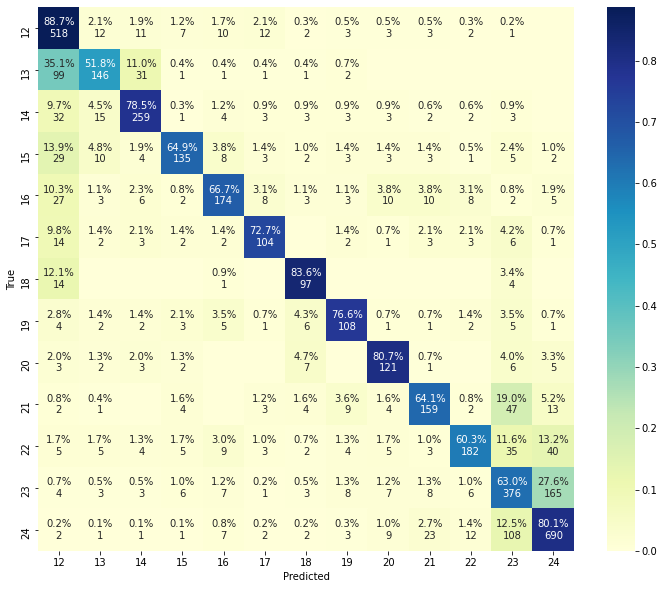

[I 2021-01-17 10:05:31,316] Trial 26 finished with value: -0.7252785557357143 and parameters: {'boosting': 'gbdt', 'num_leaves': 1780, 'max_depth': 14, 'max_bin': 205, 'min_data_in_leaf': 11, 'min_data_in_bin': 234, 'min_gain_to_split': 1.51, 'lamda_l1': 0.0037846694627333994, 'lamda_l2': 1.3322586355497456e-08, 'learning_rate': 0.14835839917591215, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.6, 'feature_fraction': 0.5}. Best is trial 9 with value: -0.7319195322425545.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[91]	training's multi_error: 0.0467082	valid_1's multi_error: 0.273077
                                                                                  FOLD0-val acc: 72.6923076923077  FOLD0-test acc: 71.20530428605257
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[93]	training's multi_error: 0.0446058	valid_1's multi_error: 0.280546
                                                                                  FOLD1-val acc: 71.94543297746144  FOLD1-test acc: 70.30547004499171
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[82]	training's multi_error: 0.0503112	valid_1's multi_error: 0.263345
                                                                                  FOLD2-val acc: 73.66548042704626  FOLD2-test acc: 68.67156050201278
Training until validation scores don't improve 

[I 2021-01-17 10:07:29,009] Trial 27 finished with value: -0.727709645040606 and parameters: {'boosting': 'gbdt', 'num_leaves': 1400, 'max_depth': 11, 'max_bin': 243, 'min_data_in_leaf': 150, 'min_data_in_bin': 160, 'min_gain_to_split': 0.36, 'lamda_l1': 1.92795016939732e-06, 'lamda_l2': 6.024729017066781e-08, 'learning_rate': 0.03914365857476705, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.63, 'feature_fraction': 0.56}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 68.57684110821691
=====================> TTA on test acc: 70.77906701397112, mse: 3.7956429078853895 ~ 37956429078.8539
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[159]	training's multi_error: 0.0482651	valid_1's multi_error: 0.274556
                                                                                  FOLD0-val acc: 72.54437869822485  FOLD0-test acc: 71.30002367984845
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[162]	training's multi_error: 0.0458654	valid_1's multi_error: 0.27847
                                                                                  FOLD1-val acc: 72.15302491103202  FOLD1-test acc: 70.9448259531139
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[77]	training's multi_error: 0.0735774	valid_1's multi_error: 0.26038
                                                            

[I 2021-01-17 10:09:20,710] Trial 28 finished with value: -0.7291931464830452 and parameters: {'boosting': 'gbdt', 'num_leaves': 1257, 'max_depth': 14, 'max_bin': 234, 'min_data_in_leaf': 58, 'min_data_in_bin': 210, 'min_gain_to_split': 1.05, 'lamda_l1': 1.600749502977854e-07, 'lamda_l2': 2.3657708914293702e-07, 'learning_rate': 0.01723423920263367, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.56, 'feature_fraction': 0.5}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 69.5240350461757
=====================> TTA on test acc: 70.77906701397112, mse: 3.8233483305706844 ~ 38233483305.70684
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	training's multi_error: 0.0268387	valid_1's multi_error: 0.269822
                                                                                  FOLD0-val acc: 73.01775147928994  FOLD0-test acc: 71.25266398295051
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[88]	training's multi_error: 0.0229698	valid_1's multi_error: 0.276097
                                                                                  FOLD1-val acc: 72.3902728351127  FOLD1-test acc: 70.32914989344067
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[38]	training's multi_error: 0.0313426	valid_1's multi_error: 0.255042
                                                            

[I 2021-01-17 10:10:46,626] Trial 29 finished with value: -0.7309702597794577 and parameters: {'boosting': 'goss', 'num_leaves': 1144, 'max_depth': 18, 'max_bin': 226, 'min_data_in_leaf': 24, 'min_data_in_bin': 207, 'min_gain_to_split': 0.75, 'lamda_l1': 0.1637834827827255, 'lamda_l2': 1.9000061080710466e-07, 'learning_rate': 0.019765740359225098, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.55, 'feature_fraction': 0.5}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 69.71347383376745
=====================> TTA on test acc: 71.39474307364434, mse: 3.577314705185887 ~ 35773147051.85887
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[103]	training's multi_error: 0.11462	valid_1's multi_error: 0.30355
                                                                                  FOLD0-val acc: 69.64497041420118  FOLD0-test acc: 67.89012550319677
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[225]	training's multi_error: 0.0829876	valid_1's multi_error: 0.27847
                                                                                  FOLD1-val acc: 72.15302491103202  FOLD1-test acc: 70.09235140895098
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[260]	training's multi_error: 0.0766153	valid_1's multi_error: 0.266904
                                                            

[I 2021-01-17 10:14:25,152] Trial 30 finished with value: -0.7187679953954249 and parameters: {'boosting': 'goss', 'num_leaves': 1076, 'max_depth': 19, 'max_bin': 205, 'min_data_in_leaf': 29, 'min_data_in_bin': 208, 'min_gain_to_split': 0.7, 'lamda_l1': 7.670776826669997, 'lamda_l2': 8.823600552015346e-08, 'learning_rate': 0.00783864943112124, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.53, 'feature_fraction': 1.0}. Best is trial 9 with value: -0.7319195322425545.


 FOLD4-test acc: 68.19796353303339
=====================> TTA on test acc: 70.18707080274686, mse: 4.013971110584892 ~ 40139711105.84892
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[117]	training's multi_error: 0.0319543	valid_1's multi_error: 0.27071
                                                                                  FOLD0-val acc: 72.92899408284023  FOLD0-test acc: 71.15794458915462
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[100]	training's multi_error: 0.0338619	valid_1's multi_error: 0.27758
                                                                                  FOLD1-val acc: 72.24199288256227  FOLD1-test acc: 71.4184229220933
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[78]	training's multi_error: 0.0348251	valid_1's multi_error: 0.258007
                                                            

[I 2021-01-17 10:16:01,779] Trial 31 finished with value: -0.732809352341244 and parameters: {'boosting': 'goss', 'num_leaves': 1143, 'max_depth': 14, 'max_bin': 227, 'min_data_in_leaf': 34, 'min_data_in_bin': 215, 'min_gain_to_split': 0.93, 'lamda_l1': 0.12034281794106512, 'lamda_l2': 3.446632992392527e-07, 'learning_rate': 0.017909993670152304, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.5700000000000001, 'feature_fraction': 0.5}. Best is trial 31 with value: -0.732809352341244.


 FOLD4-test acc: 69.5240350461757
=====================> TTA on test acc: 71.44210277054228, mse: 3.686005209566659 ~ 36860052095.66659
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[89]	training's multi_error: 0.0238731	valid_1's multi_error: 0.269822
                                                                                  FOLD0-val acc: 73.01775147928994  FOLD0-test acc: 71.32370352829741
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[145]	training's multi_error: 0.0159306	valid_1's multi_error: 0.275208
                                                                                  FOLD1-val acc: 72.47924080664293  FOLD1-test acc: 70.77906701397112
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[74]	training's multi_error: 0.0255631	valid_1's multi_error: 0.251186
                                                           

[I 2021-01-17 10:17:59,603] Trial 32 finished with value: -0.732868243172103 and parameters: {'boosting': 'goss', 'num_leaves': 1128, 'max_depth': 19, 'max_bin': 221, 'min_data_in_leaf': 27, 'min_data_in_bin': 254, 'min_gain_to_split': 0.33999999999999997, 'lamda_l1': 0.1299335512702522, 'lamda_l2': 1.1000844655629761e-06, 'learning_rate': 0.018519448182080622, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.58, 'feature_fraction': 0.53}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 70.30547004499171
=====================> TTA on test acc: 71.44210277054228, mse: 3.557660430973242 ~ 35576604309.732414
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[43]	training's multi_error: 0.0617586	valid_1's multi_error: 0.287574
                                                                                  FOLD0-val acc: 71.24260355029585  FOLD0-test acc: 70.37650959033861
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[79]	training's multi_error: 0.0427534	valid_1's multi_error: 0.280546
                                                                                  FOLD1-val acc: 71.94543297746144  FOLD1-test acc: 70.06867156050201
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[86]	training's multi_error: 0.0397896	valid_1's multi_error: 0.261566
                                                          

[I 2021-01-17 10:19:04,342] Trial 33 finished with value: -0.7220225736486345 and parameters: {'boosting': 'goss', 'num_leaves': 989, 'max_depth': 20, 'max_bin': 215, 'min_data_in_leaf': 3, 'min_data_in_bin': 256, 'min_gain_to_split': 0.21000000000000002, 'lamda_l1': 6.397084046833024, 'lamda_l2': 1.0242019134615802e-06, 'learning_rate': 0.029827315389464037, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.59, 'feature_fraction': 0.53}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.90291262135922
=====================> TTA on test acc: 71.08690504380772, mse: 3.9720577788302154 ~ 39720577788.302155
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[357]	training's multi_logloss: 0.292125	valid_1's multi_logloss: 1.07345
                                                                                  FOLD0-val acc: 72.63313609467455  FOLD0-test acc: 70.61330807482832
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[320]	training's multi_logloss: 0.313599	valid_1's multi_logloss: 1.08283
                                                                                  FOLD1-val acc: 72.33096085409252  FOLD1-test acc: 70.40018943878759
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[291]	training's multi_logloss: 0.340725	valid_1's multi_logloss: 1.07538
                                                

[I 2021-01-17 10:21:56,083] Trial 34 finished with value: -0.7304382769343076 and parameters: {'boosting': 'goss', 'num_leaves': 1461, 'max_depth': 23, 'max_bin': 193, 'min_data_in_leaf': 37, 'min_data_in_bin': 249, 'min_gain_to_split': 3.43, 'lamda_l1': 0.02512818307368513, 'lamda_l2': 1.1147869735097925e-08, 'learning_rate': 0.010051686883334254, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.65, 'feature_fraction': 0.54}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.7608335306654
=====================> TTA on test acc: 71.06322519535875, mse: 3.6604309732417715 ~ 36604309732.41771
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[46]	training's multi_error: 0.0647242	valid_1's multi_error: 0.283728
                                                                                  FOLD0-val acc: 71.62721893491124  FOLD0-test acc: 69.7608335306654
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[72]	training's multi_error: 0.0527564	valid_1's multi_error: 0.283511
                                                                                  FOLD1-val acc: 71.64887307236062  FOLD1-test acc: 69.5240350461757
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[48]	training's multi_error: 0.0636485	valid_1's multi_error: 0.253559
                                                             

[I 2021-01-17 10:23:21,298] Trial 35 finished with value: -0.7252829076207121 and parameters: {'boosting': 'goss', 'num_leaves': 929, 'max_depth': 25, 'max_bin': 226, 'min_data_in_leaf': 47, 'min_data_in_bin': 235, 'min_gain_to_split': 0.48, 'lamda_l1': 0.31525487785108575, 'lamda_l2': 3.587074450183142e-08, 'learning_rate': 0.017458090555007213, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.58, 'feature_fraction': 0.67}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 68.9793985318494
=====================> TTA on test acc: 71.30002367984845, mse: 3.8891783092588206 ~ 38891783092.58821
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[50]	training's multi_logloss: 0.335684	valid_1's multi_logloss: 1.13068
                                                                                  FOLD0-val acc: 71.80473372781066  FOLD0-test acc: 70.40018943878759
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	training's multi_logloss: 0.323734	valid_1's multi_logloss: 1.13651
                                                                                  FOLD1-val acc: 71.91577698695136  FOLD1-test acc: 70.82642671086904
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[49]	training's multi_logloss: 0.340487	valid_1's multi_logloss: 1.09976
                                                     

[I 2021-01-17 10:24:16,616] Trial 36 finished with value: -0.7272393606940554 and parameters: {'boosting': 'goss', 'num_leaves': 1194, 'max_depth': 15, 'max_bin': 180, 'min_data_in_leaf': 21, 'min_data_in_bin': 149, 'min_gain_to_split': 1.6500000000000001, 'lamda_l1': 1.054253683591346, 'lamda_l2': 4.10408288068792e-06, 'learning_rate': 0.0495661969583019, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.5, 'feature_fraction': 0.61}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.68979398531849
=====================> TTA on test acc: 70.82642671086904, mse: 3.7497040018943877 ~ 37497040018.94388
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[155]	training's multi_error: 0.0584223	valid_1's multi_error: 0.286982
                                                                                  FOLD0-val acc: 71.30177514792899  FOLD0-test acc: 70.13971110584892
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[150]	training's multi_error: 0.0569057	valid_1's multi_error: 0.271649
                                                                                  FOLD1-val acc: 72.83511269276394  FOLD1-test acc: 70.44754913568553
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[79]	training's multi_error: 0.0749111	valid_1's multi_error: 0.266904
                                                        

[I 2021-01-17 10:26:12,786] Trial 37 finished with value: -0.7217850449577797 and parameters: {'boosting': 'goss', 'num_leaves': 438, 'max_depth': 13, 'max_bin': 165, 'min_data_in_leaf': 70, 'min_data_in_bin': 180, 'min_gain_to_split': 0.94, 'lamda_l1': 0.07257080840497238, 'lamda_l2': 7.215169003791492e-07, 'learning_rate': 0.015255905688673809, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.71, 'feature_fraction': 0.71}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 68.36372247217618
=====================> TTA on test acc: 71.30002367984845, mse: 3.8044044518115085 ~ 38044044518.11508
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.482987	valid_1's multi_logloss: 1.01577
                                                                                  FOLD0-val acc: 71.21301775147928  FOLD0-test acc: 69.07411792564527
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.4842	valid_1's multi_logloss: 1.01232
                                                                                  FOLD1-val acc: 71.79715302491103  FOLD1-test acc: 70.73170731707317
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.422833	valid_1's multi_logloss: 1.02928
                                                   

[I 2021-01-17 10:28:36,771] Trial 38 finished with value: -0.7219040900699811 and parameters: {'boosting': 'goss', 'num_leaves': 1327, 'max_depth': 12, 'max_bin': 195, 'min_data_in_leaf': 237, 'min_data_in_bin': 62, 'min_gain_to_split': 1.37, 'lamda_l1': 0.007629045612943843, 'lamda_l2': 1.259861523734786e-07, 'learning_rate': 0.032133892988644684, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.6799999999999999, 'feature_fraction': 0.81}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.0504380771963
=====================> TTA on test acc: 70.42386928723656, mse: 4.021075065119583 ~ 40210750651.19583
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[64]	training's multi_error: 0.0604982	valid_1's multi_error: 0.282249
                                                                                  FOLD0-val acc: 71.77514792899409  FOLD0-test acc: 70.25811034809377
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[25]	training's multi_error: 0.0950652	valid_1's multi_error: 0.27758
                                                                                  FOLD1-val acc: 72.24199288256227  FOLD1-test acc: 70.5422685294814
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[50]	training's multi_error: 0.07254	valid_1's multi_error: 0.262752
                                                                

[I 2021-01-17 10:29:31,265] Trial 39 finished with value: -0.7249263338176559 and parameters: {'boosting': 'goss', 'num_leaves': 1612, 'max_depth': 22, 'max_bin': 253, 'min_data_in_leaf': 101, 'min_data_in_bin': 224, 'min_gain_to_split': 0.12000000000000001, 'lamda_l1': 9.72314966731411e-06, 'lamda_l2': 1.0846272341663588e-08, 'learning_rate': 0.05054997935539017, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.58, 'feature_fraction': 0.56}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 73.6061684460261  FOLD4-test acc: 68.74260004735969
=====================> TTA on test acc: 71.03954534690978, mse: 3.8444233956902676 ~ 38444233956.90268
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[338]	training's multi_error: 0.111358	valid_1's multi_error: 0.286686
                                                                                  FOLD0-val acc: 71.33136094674556  FOLD0-test acc: 70.28179019654274
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[195]	training's multi_error: 0.142931	valid_1's multi_error: 0.28796
                                                                                  FOLD1-val acc: 71.20403321470937  FOLD1-test acc: 70.68434762017523
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[118]	training's

[I 2021-01-17 10:32:27,790] Trial 40 finished with value: -0.7190565534474651 and parameters: {'boosting': 'goss', 'num_leaves': 981, 'max_depth': 15, 'max_bin': 227, 'min_data_in_leaf': 195, 'min_data_in_bin': 83, 'min_gain_to_split': 1.87, 'lamda_l1': 0.0006928043968844684, 'lamda_l2': 3.205816641386995e-08, 'learning_rate': 0.008751756276409782, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.53, 'feature_fraction': 0.6}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.38195595548189
=====================> TTA on test acc: 71.27634383139949, mse: 4.242718446601942 ~ 42427184466.01942
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[121]	training's multi_error: 0.0194247	valid_1's multi_error: 0.27426
                                                                                  FOLD0-val acc: 72.57396449704142  FOLD0-test acc: 71.22898413450154
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[60]	training's multi_error: 0.0308239	valid_1's multi_error: 0.27758
                                                                                  FOLD1-val acc: 72.24199288256227  FOLD1-test acc: 70.4712289841345
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	training's multi_error: 0.0302312	valid_1's multi_error: 0.26038
                                                              

[I 2021-01-17 10:34:03,084] Trial 41 finished with value: -0.7287185102514968 and parameters: {'boosting': 'goss', 'num_leaves': 1144, 'max_depth': 18, 'max_bin': 230, 'min_data_in_leaf': 26, 'min_data_in_bin': 205, 'min_gain_to_split': 0.61, 'lamda_l1': 0.26020912849397443, 'lamda_l2': 1.4151541609673858e-07, 'learning_rate': 0.019911266423848283, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.53, 'feature_fraction': 0.52}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.12147762254321
=====================> TTA on test acc: 71.20530428605257, mse: 3.632488752071987 ~ 36324887520.719864
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[89]	training's multi_error: 0.0662811	valid_1's multi_error: 0.281657
                                                                                  FOLD0-val acc: 71.83431952662723  FOLD0-test acc: 70.7080274686242
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[79]	training's multi_error: 0.0693539	valid_1's multi_error: 0.276987
                                                                                  FOLD1-val acc: 72.30130486358244  FOLD1-test acc: 70.96850580156287
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[72]	training's multi_error: 0.070243	valid_1's multi_error: 0.261269
                                                            

[I 2021-01-17 10:35:03,746] Trial 42 finished with value: -0.7261122926712853 and parameters: {'boosting': 'goss', 'num_leaves': 1092, 'max_depth': 18, 'max_bin': 217, 'min_data_in_leaf': 53, 'min_data_in_bin': 245, 'min_gain_to_split': 0.86, 'lamda_l1': 2.4720089621697654, 'lamda_l2': 3.034594304735526e-07, 'learning_rate': 0.02403401739010036, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.56, 'feature_fraction': 0.5}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.23987686478806
=====================> TTA on test acc: 71.03954534690978, mse: 4.073644328676297 ~ 40736443286.76296
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[58]	training's multi_error: 0.0107503	valid_1's multi_error: 0.27929
                                                                                  FOLD0-val acc: 72.07100591715975  FOLD0-test acc: 71.32370352829741
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[248]	training's multi_error: 0.00125963	valid_1's multi_error: 0.279656
                                                                                  FOLD1-val acc: 72.03440094899169  FOLD1-test acc: 70.89746625621596
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[90]	training's multi_error: 0.0074837	valid_1's multi_error: 0.260676
                                                          

[I 2021-01-17 10:37:55,194] Trial 43 finished with value: -0.7249249299837858 and parameters: {'boosting': 'goss', 'num_leaves': 1209, 'max_depth': 20, 'max_bin': 241, 'min_data_in_leaf': 13, 'min_data_in_bin': 218, 'min_gain_to_split': 0.33999999999999997, 'lamda_l1': 0.02810365807010771, 'lamda_l2': 5.3201721950592945e-08, 'learning_rate': 0.01344948427579572, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.62, 'feature_fraction': 0.52}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.73715368221643
=====================> TTA on test acc: 71.51314231588918, mse: 3.4863840871418423 ~ 34863840871.41843
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[88]	training's multi_error: 0.0623517	valid_1's multi_error: 0.276923
                                                                                  FOLD0-val acc: 72.3076923076923  FOLD0-test acc: 70.30547004499171
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	training's multi_error: 0.0695762	valid_1's multi_error: 0.27847
                                                                                  FOLD1-val acc: 72.15302491103202  FOLD1-test acc: 70.68434762017523
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[120]	training's multi_error: 0.0510522	valid_1's multi_error: 0.258007
                                                           

[I 2021-01-17 10:39:23,358] Trial 44 finished with value: -0.7281859658727986 and parameters: {'boosting': 'goss', 'num_leaves': 1409, 'max_depth': 17, 'max_bin': 195, 'min_data_in_leaf': 69, 'min_data_in_bin': 152, 'min_gain_to_split': 0.66, 'lamda_l1': 0.1229308404470381, 'lamda_l2': 8.53440248069338e-07, 'learning_rate': 0.02055613203834873, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.55, 'feature_fraction': 0.5700000000000001}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 74.19928825622776  FOLD4-test acc: 69.87923277291024
=====================> TTA on test acc: 71.93937958797065, mse: 3.7838029836609044 ~ 37838029836.60905
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[86]	training's multi_error: 0.035513	valid_1's multi_error: 0.276036
                                                                                  FOLD0-val acc: 72.39644970414201  FOLD0-test acc: 70.99218565001183
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[82]	training's multi_error: 0.0378631	valid_1's multi_error: 0.271649
                                                                                  FOLD1-val acc: 72.83511269276394  FOLD1-test acc: 70.82642671086904
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[59]	training's

[I 2021-01-17 10:40:29,722] Trial 45 finished with value: -0.7321594474509887 and parameters: {'boosting': 'goss', 'num_leaves': 684, 'max_depth': 11, 'max_bin': 218, 'min_data_in_leaf': 33, 'min_data_in_bin': 173, 'min_gain_to_split': 1.26, 'lamda_l1': 0.7918099659604084, 'lamda_l2': 3.250029269520746e-07, 'learning_rate': 0.031010707310943665, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.64, 'feature_fraction': 0.5}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 74.97034400948992  FOLD4-test acc: 69.85555292446128
=====================> TTA on test acc: 70.99218565001183, mse: 3.756807956429079 ~ 37568079564.29079
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[53]	training's multi_error: 0.0452254	valid_1's multi_error: 0.272485
                                                                                  FOLD0-val acc: 72.75147928994082  FOLD0-test acc: 71.1105848922567
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[21]	training's multi_error: 0.0618702	valid_1's multi_error: 0.283511
                                                                                  FOLD1-val acc: 71.64887307236062  FOLD1-test acc: 69.97395216670613
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[43]	training's 

[I 2021-01-17 10:41:28,789] Trial 46 finished with value: -0.7318612029452434 and parameters: {'boosting': 'goss', 'num_leaves': 575, 'max_depth': 11, 'max_bin': 179, 'min_data_in_leaf': 36, 'min_data_in_bin': 168, 'min_gain_to_split': 1.27, 'lamda_l1': 0.7285313091848071, 'lamda_l2': 2.0020320595034857e-06, 'learning_rate': 0.036302222887050595, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.64, 'feature_fraction': 0.52}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.92659246980818
=====================> TTA on test acc: 71.58418186123609, mse: 3.699739521667061 ~ 36997395216.670616
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[35]	training's multi_error: 0.032325	valid_1's multi_error: 0.283728
                                                                                  FOLD0-val acc: 71.62721893491124  FOLD0-test acc: 69.45299550082879
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[28]	training's multi_error: 0.0369739	valid_1's multi_error: 0.281732
                                                                                  FOLD1-val acc: 71.8268090154211  FOLD1-test acc: 69.64243428842055
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[10]	training's multi_error: 0.057128	valid_1's multi_error: 0.260973
                                                             

[I 2021-01-17 10:41:57,856] Trial 47 finished with value: -0.7242746039433693 and parameters: {'boosting': 'goss', 'num_leaves': 708, 'max_depth': 11, 'max_bin': 58, 'min_data_in_leaf': 9, 'min_data_in_bin': 124, 'min_gain_to_split': 1.7500000000000002, 'lamda_l1': 2.120018964150648, 'lamda_l2': 0.00014012422914223992, 'learning_rate': 0.09225953234679588, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.67, 'feature_fraction': 0.58}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.14515747099217
=====================> TTA on test acc: 71.44210277054228, mse: 3.618991238456074 ~ 36189912384.56074
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.403819	valid_1's multi_logloss: 1.04792
                                                                                  FOLD0-val acc: 71.71597633136095  FOLD0-test acc: 70.82642671086904
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[63]	training's multi_logloss: 0.384881	valid_1's multi_logloss: 1.0417
                                                                                  FOLD1-val acc: 73.48754448398577  FOLD1-test acc: 69.90291262135922
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[68]	training's multi_logloss: 0.367868	valid_1's multi_logloss: 1.04681
                                                      

[I 2021-01-17 10:42:42,429] Trial 48 finished with value: -0.7258756062807528 and parameters: {'boosting': 'goss', 'num_leaves': 210, 'max_depth': 8, 'max_bin': 217, 'min_data_in_leaf': 71, 'min_data_in_bin': 146, 'min_gain_to_split': 2.85, 'lamda_l1': 0.0381087443718992, 'lamda_l2': 3.4608005722861047e-07, 'learning_rate': 0.05779509781961661, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.6, 'feature_fraction': 0.55}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.99763201515509
=====================> TTA on test acc: 71.1105848922567, mse: 3.813402794222117 ~ 38134027942.22117
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[46]	training's multi_error: 0.0785884	valid_1's multi_error: 0.283136
                                                                                  FOLD0-val acc: 71.68639053254438  FOLD0-test acc: 70.63698792327729
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[23]	training's multi_error: 0.0955098	valid_1's multi_error: 0.283215
                                                                                  FOLD1-val acc: 71.6785290628707  FOLD1-test acc: 71.13426474070566
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[77]	training's multi_error: 0.054016	valid_1's multi_error: 0.263049
                                                              

[I 2021-01-17 10:43:36,277] Trial 49 finished with value: -0.724867442986797 and parameters: {'boosting': 'goss', 'num_leaves': 344, 'max_depth': 10, 'max_bin': 248, 'min_data_in_leaf': 93, 'min_data_in_bin': 119, 'min_gain_to_split': 1.01, 'lamda_l1': 0.001456112965348913, 'lamda_l2': 3.3316828593403686e-05, 'learning_rate': 0.044117058515749145, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.73, 'feature_fraction': 0.5}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 73.69513641755636  FOLD4-test acc: 68.74260004735969
=====================> TTA on test acc: 70.75538716552214, mse: 3.96045465309022 ~ 39604546530.9022
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[4]	training's multi_error: 0.151839	valid_1's multi_error: 0.373077
                                                                                  FOLD0-val acc: 62.69230769230769  FOLD0-test acc: 61.99384323940327
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[4]	training's multi_error: 0.142931	valid_1's multi_error: 0.384045
                                                                                  FOLD1-val acc: 61.59549228944247  FOLD1-test acc: 60.45465309022022
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[2]	training's multi_

[I 2021-01-17 10:43:51,588] Trial 50 finished with value: -0.6409243544118989 and parameters: {'boosting': 'goss', 'num_leaves': 906, 'max_depth': 12, 'max_bin': 206, 'min_data_in_leaf': 52, 'min_data_in_bin': 177, 'min_gain_to_split': 4.95, 'lamda_l1': 0.009453068546349504, 'lamda_l2': 5.83547843479356e-06, 'learning_rate': 0.489477750964416, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.69, 'feature_fraction': 0.61}. Best is trial 32 with value: -0.732868243172103.


Early stopping, best iteration is:
[3]	training's multi_error: 0.156417	valid_1's multi_error: 0.337189
                                                                                  FOLD4-val acc: 66.28113879003558  FOLD4-test acc: 60.430973241771255
=====================> TTA on test acc: 68.55316125976793, mse: 4.487094482595311 ~ 44870944825.95312
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[25]	training's multi_error: 0.0570878	valid_1's multi_error: 0.276923
                                                                                  FOLD0-val acc: 72.3076923076923  FOLD0-test acc: 70.85010655931802
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[25]	training's multi_error: 0.0554238	valid_1's multi_error: 0.276987
                                                                                  FOLD1-val acc: 72.30130486358244  FOLD1-test acc: 70.56594837793038
Training

[I 2021-01-17 10:44:37,960] Trial 51 finished with value: -0.728363901815859 and parameters: {'boosting': 'goss', 'num_leaves': 589, 'max_depth': 11, 'max_bin': 158, 'min_data_in_leaf': 37, 'min_data_in_bin': 165, 'min_gain_to_split': 1.28, 'lamda_l1': 0.594886819726271, 'lamda_l2': 2.4678324920423703e-06, 'learning_rate': 0.03517696509537646, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.65, 'feature_fraction': 0.52}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 68.52948141131897
=====================> TTA on test acc: 71.56050201278713, mse: 3.8430026047833294 ~ 38430026047.83329
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[82]	training's multi_error: 0.070952	valid_1's multi_error: 0.283728
                                                                                  FOLD0-val acc: 71.62721893491124  FOLD0-test acc: 71.03954534690978
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[28]	training's multi_error: 0.105809	valid_1's multi_error: 0.284401
                                                                                  FOLD1-val acc: 71.55990510083036  FOLD1-test acc: 71.22898413450154
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	training's multi_error: 0.0860996	valid_1's multi_error: 0.260083
                                                            

[I 2021-01-17 10:45:42,985] Trial 52 finished with value: -0.7271808910133575 and parameters: {'boosting': 'goss', 'num_leaves': 513, 'max_depth': 8, 'max_bin': 176, 'min_data_in_leaf': 35, 'min_data_in_bin': 193, 'min_gain_to_split': 1.2200000000000002, 'lamda_l1': 3.7770119797290644, 'lamda_l2': 1.049654379797626e-06, 'learning_rate': 0.028750905081920058, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.64, 'feature_fraction': 0.53}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.97395216670613
=====================> TTA on test acc: 70.99218565001183, mse: 3.8920198910726973 ~ 38920198910.726974
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[45]	training's multi_error: 0.0422598	valid_1's multi_error: 0.294379
                                                                                  FOLD0-val acc: 70.56213017751479  FOLD0-test acc: 69.5950745915226
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[126]	training's multi_error: 0.0220806	valid_1's multi_error: 0.269573
                                                                                  FOLD1-val acc: 73.04270462633453  FOLD1-test acc: 70.96850580156287
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[57]	training's multi_error: 0.0366775	valid_1's multi_error: 0.253559
                                                         

[I 2021-01-17 10:47:29,407] Trial 53 finished with value: -0.7248134655744839 and parameters: {'boosting': 'goss', 'num_leaves': 713, 'max_depth': 13, 'max_bin': 184, 'min_data_in_leaf': 19, 'min_data_in_bin': 172, 'min_gain_to_split': 1.4100000000000001, 'lamda_l1': 0.7240654524165271, 'lamda_l2': 1.7355428231762407e-05, 'learning_rate': 0.024776424115387007, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.62, 'feature_fraction': 0.87}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 72.8944246737841  FOLD4-test acc: 68.50580156286999
=====================> TTA on test acc: 71.67890125503197, mse: 3.6343831399479045 ~ 36343831399.47904
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[60]	training's multi_error: 0.0765866	valid_1's multi_error: 0.27426
                                                                                  FOLD0-val acc: 72.57396449704142  FOLD0-test acc: 71.03954534690978
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[82]	training's multi_error: 0.0704653	valid_1's multi_error: 0.277877
                                                                                  FOLD1-val acc: 72.21233689205219  FOLD1-test acc: 70.82642671086904
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[89]	training's 

[I 2021-01-17 10:48:57,091] Trial 54 finished with value: -0.7280067664792549 and parameters: {'boosting': 'goss', 'num_leaves': 327, 'max_depth': 10, 'max_bin': 199, 'min_data_in_leaf': 63, 'min_data_in_bin': 159, 'min_gain_to_split': 0.95, 'lamda_l1': 0.3345744604143929, 'lamda_l2': 2.72932230325968e-08, 'learning_rate': 0.015720056311926696, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.58, 'feature_fraction': 0.52}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 70.44754913568553
=====================> TTA on test acc: 71.79730049727682, mse: 3.8894151077433103 ~ 38894151077.433105
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[64]	training's multi_error: 0.0209816	valid_1's multi_error: 0.284615
                                                                                  FOLD0-val acc: 71.53846153846153  FOLD0-test acc: 69.73715368221643
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[108]	training's multi_error: 0.00281565	valid_1's multi_error: 0.270759
                                                                                  FOLD1-val acc: 72.9240806642942  FOLD1-test acc: 70.80274686242008
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[34]	training's multi_error: 0.0505335	valid_1's multi_error: 0.256524
                                                        

[I 2021-01-17 10:49:57,130] Trial 55 finished with value: -0.7279523679167808 and parameters: {'boosting': 'goss', 'num_leaves': 825, 'max_depth': 7, 'max_bin': 187, 'min_data_in_leaf': 43, 'min_data_in_bin': 186, 'min_gain_to_split': 0.31, 'lamda_l1': 0.07146172655419457, 'lamda_l2': 4.52289941783785e-07, 'learning_rate': 0.07540238967631485, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.59}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 74.11032028469751  FOLD4-test acc: 69.61875443997158
=====================> TTA on test acc: 70.77906701397112, mse: 3.5223774567842767 ~ 35223774567.842766
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[130]	training's multi_error: 7.414e-05	valid_1's multi_error: 0.264201
                                                                                  FOLD0-val acc: 73.57988165680473  FOLD0-test acc: 72.03409898176652
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[72]	training's multi_error: 0.000592768	valid_1's multi_error: 0.277877
                                                                                  FOLD1-val acc: 72.21233689205219  FOLD1-test acc: 70.56594837793038
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[40]	train

[I 2021-01-17 10:51:41,748] Trial 56 finished with value: -0.7323910800395882 and parameters: {'boosting': 'goss', 'num_leaves': 643, 'max_depth': 11, 'max_bin': 173, 'min_data_in_leaf': 1, 'min_data_in_bin': 147, 'min_gain_to_split': 1.11, 'lamda_l1': 0.00024953411162453133, 'lamda_l2': 8.46457569208431e-08, 'learning_rate': 0.03420947148181141, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.66, 'feature_fraction': 0.54}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.40563580393085
=====================> TTA on test acc: 71.77362064882786, mse: 3.33057068434762 ~ 33305706843.4762
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[57]	training's multi_error: 0.141014	valid_1's multi_error: 0.286982
                                                                                  FOLD0-val acc: 71.30177514792899  FOLD0-test acc: 69.83187307601231
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[158]	training's multi_error: 0.0720213	valid_1's multi_error: 0.275208
                                                                                  FOLD1-val acc: 72.47924080664293  FOLD1-test acc: 70.5422685294814
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[74]	training's multi_error: 0.125222	valid_1's multi_error: 0.264828
                                                               

[I 2021-01-17 10:54:00,191] Trial 57 finished with value: -0.7246913320277678 and parameters: {'boosting': 'gbdt', 'num_leaves': 648, 'max_depth': 15, 'max_bin': 166, 'min_data_in_leaf': 122, 'min_data_in_bin': 142, 'min_gain_to_split': 0.52, 'lamda_l1': 0.00022244315360777674, 'lamda_l2': 7.987278279205599e-08, 'learning_rate': 0.011393239654247598, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.78, 'feature_fraction': 0.56}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 70.06867156050201
=====================> TTA on test acc: 71.46578261899124, mse: 4.101823348330571 ~ 41018233483.30571
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[140]	training's multi_error: 0.0303974	valid_1's multi_error: 0.269527
                                                                                  FOLD0-val acc: 73.04733727810651  FOLD0-test acc: 71.79730049727682
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[68]	training's multi_error: 0.0609069	valid_1's multi_error: 0.281139
                                                                                  FOLD1-val acc: 71.88612099644128  FOLD1-test acc: 70.75538716552214
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[96]	training's multi_error: 0.0400119	valid_1's multi_error: 0.259193
                                                          

[I 2021-01-17 10:55:53,405] Trial 58 finished with value: -0.7297245677946471 and parameters: {'boosting': 'gbdt', 'num_leaves': 753, 'max_depth': 6, 'max_bin': 147, 'min_data_in_leaf': 1, 'min_data_in_bin': 112, 'min_gain_to_split': 1.1400000000000001, 'lamda_l1': 2.6827175607804864e-05, 'lamda_l2': 2.0921737695905024e-08, 'learning_rate': 0.025262967778810565, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.72, 'feature_fraction': 0.54}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 70.77906701397112
=====================> TTA on test acc: 71.98673928486858, mse: 3.53540137343121 ~ 35354013734.3121
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[21]	training's multi_error: 0.217972	valid_1's multi_error: 0.307692
                                                                                  FOLD0-val acc: 69.23076923076923  FOLD0-test acc: 69.50035519772673
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[178]	training's multi_error: 0.0823948	valid_1's multi_error: 0.27847
                                                                                  FOLD1-val acc: 72.15302491103202  FOLD1-test acc: 69.80819322756334
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[28]	training's multi_error: 0.211025	valid_1's multi_error: 0.278173
                                                               

[I 2021-01-17 10:56:54,020] Trial 59 finished with value: -0.7137284423761291 and parameters: {'boosting': 'goss', 'num_leaves': 1295, 'max_depth': 9, 'max_bin': 213, 'min_data_in_leaf': 222, 'min_data_in_bin': 94, 'min_gain_to_split': 1.7000000000000002, 'lamda_l1': 0.0004916594794273546, 'lamda_l2': 1.543966945421698e-07, 'learning_rate': 0.043715028729363274, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.67, 'feature_fraction': 0.5700000000000001}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 68.95571868340042
=====================> TTA on test acc: 70.5422685294814, mse: 4.179493251243192 ~ 41794932512.43192
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[9]	training's multi_error: 0.0150504	valid_1's multi_error: 0.29645
                                                                                  FOLD0-val acc: 70.35502958579882  FOLD0-test acc: 68.43476201752308
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[7]	training's multi_error: 0.0137819	valid_1's multi_error: 0.324437
                                                                                  FOLD1-val acc: 67.55634638196916  FOLD1-test acc: 67.81908595784986
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[8]	training's multi_error: 0.0136337	valid_1's multi_error: 0.317319
                                                                

[I 2021-01-17 10:57:16,674] Trial 60 finished with value: -0.688693451816912 and parameters: {'boosting': 'gbdt', 'num_leaves': 1063, 'max_depth': 14, 'max_bin': 237, 'min_data_in_leaf': 1, 'min_data_in_bin': 138, 'min_gain_to_split': 4.38, 'lamda_l1': 0.00011387615763659209, 'lamda_l2': 4.762362883796015e-08, 'learning_rate': 0.09941696402619223, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.61, 'feature_fraction': 0.5}. Best is trial 32 with value: -0.732868243172103.


Early stopping, best iteration is:
[10]	training's multi_error: 0.0160788	valid_1's multi_error: 0.283808
                                                                                  FOLD4-val acc: 71.61921708185054  FOLD4-test acc: 68.31636277527824
=====================> TTA on test acc: 71.27634383139949, mse: 3.689083589865025 ~ 36890835898.650246
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[105]	training's multi_error: 0.0175712	valid_1's multi_error: 0.265089
                                                                                  FOLD0-val acc: 73.49112426035504  FOLD0-test acc: 71.39474307364434
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[34]	training's multi_error: 0.0378631	valid_1's multi_error: 0.278766
                                                                                  FOLD1-val acc: 72.12336892052194  FOLD1-test acc: 70.28179019654274
Trai

[I 2021-01-17 10:58:20,142] Trial 61 finished with value: -0.7287734703475192 and parameters: {'boosting': 'goss', 'num_leaves': 572, 'max_depth': 11, 'max_bin': 174, 'min_data_in_leaf': 30, 'min_data_in_bin': 166, 'min_gain_to_split': 1.4800000000000002, 'lamda_l1': 0.0017140896501625107, 'lamda_l2': 2.4650942777971954e-06, 'learning_rate': 0.03394550800642867, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.64, 'feature_fraction': 0.54}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.16883731944115
=====================> TTA on test acc: 71.655221406583, mse: 3.679848448969927 ~ 36798484489.699265
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[74]	training's multi_error: 0.00934164	valid_1's multi_error: 0.270414
                                                                                  FOLD0-val acc: 72.9585798816568  FOLD0-test acc: 70.44754913568553
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[75]	training's multi_error: 0.00852104	valid_1's multi_error: 0.275504
                                                                                  FOLD1-val acc: 72.44958481613286  FOLD1-test acc: 69.66611413686952
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[33]	training's multi_error: 0.018524	valid_1's multi_error: 0.261566
                                                            

[I 2021-01-17 10:59:08,281] Trial 62 finished with value: -0.7298436129068486 and parameters: {'boosting': 'goss', 'num_leaves': 472, 'max_depth': 13, 'max_bin': 189, 'min_data_in_leaf': 17, 'min_data_in_bin': 153, 'min_gain_to_split': 2.03, 'lamda_l1': 1.4346189671069789e-05, 'lamda_l2': 3.1611223446579437e-07, 'learning_rate': 0.062267459655119956, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.7, 'feature_fraction': 0.51}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 75.08896797153025  FOLD4-test acc: 70.37650959033861
=====================> TTA on test acc: 71.01586549846081, mse: 3.477148946246744 ~ 34771489462.46744
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[127]	training's multi_error: 0.0133452	valid_1's multi_error: 0.279586
                                                                                  FOLD0-val acc: 72.0414201183432  FOLD0-test acc: 71.1105848922567
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[83]	training's multi_error: 0.025489	valid_1's multi_error: 0.277284
                                                                                  FOLD1-val acc: 72.27164887307237  FOLD1-test acc: 70.63698792327729
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[44]	training's m

[I 2021-01-17 11:00:44,345] Trial 63 finished with value: -0.7305597085640886 and parameters: {'boosting': 'goss', 'num_leaves': 657, 'max_depth': 10, 'max_bin': 119, 'min_data_in_leaf': 31, 'min_data_in_bin': 124, 'min_gain_to_split': 0.86, 'lamda_l1': 0.011589033611341613, 'lamda_l2': 1.6262447540503558e-06, 'learning_rate': 0.02959776026891028, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.66, 'feature_fraction': 0.54}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 73.7841043890866  FOLD4-test acc: 70.13971110584892
=====================> TTA on test acc: 71.63154155813403, mse: 3.6135448733128106 ~ 36135448733.128105
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[168]	training's multi_error: 0.0246886	valid_1's multi_error: 0.271598
                                                                                  FOLD0-val acc: 72.84023668639054  FOLD0-test acc: 71.3473833767464
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[61]	training's multi_error: 0.0486811	valid_1's multi_error: 0.280842
                                                                                  FOLD1-val acc: 71.91577698695136  FOLD1-test acc: 71.1816244376036
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[56]	training's

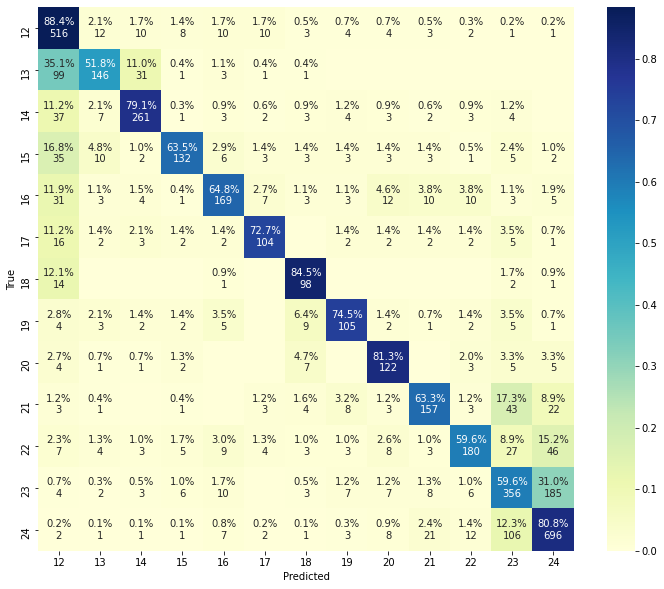

[I 2021-01-17 11:02:30,429] Trial 64 finished with value: -0.7301407343454975 and parameters: {'boosting': 'goss', 'num_leaves': 406, 'max_depth': 12, 'max_bin': 95, 'min_data_in_leaf': 44, 'min_data_in_bin': 192, 'min_gain_to_split': 1.08, 'lamda_l1': 0.0036421213551528124, 'lamda_l2': 1.1054194953761357e-05, 'learning_rate': 0.0209614947416696, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.63, 'feature_fraction': 0.59}. Best is trial 32 with value: -0.732868243172103.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[97]	training's multi_error: 0.0332147	valid_1's multi_error: 0.272781
                                                                                  FOLD0-val acc: 72.72189349112426  FOLD0-test acc: 71.13426474070566
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	training's multi_error: 0.0503853	valid_1's multi_error: 0.26809
                                                                                  FOLD1-val acc: 73.19098457888494  FOLD1-test acc: 69.90291262135922
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[86]	training's multi_error: 0.0359366	valid_1's multi_error: 0.255635
                                                                                  FOLD2-val acc: 74.43653618030842  FOLD2-test acc: 70.77906701397112
Training until validation scores don't improve 

[I 2021-01-17 11:03:32,797] Trial 65 finished with value: -0.7319206553096507 and parameters: {'boosting': 'goss', 'num_leaves': 861, 'max_depth': 11, 'max_bin': 220, 'min_data_in_leaf': 56, 'min_data_in_bin': 174, 'min_gain_to_split': 1.31, 'lamda_l1': 0.00010445330537071523, 'lamda_l2': 6.068527234922718e-07, 'learning_rate': 0.03728921836180501, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.6, 'feature_fraction': 0.51}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.47667534927776
=====================> TTA on test acc: 71.1105848922567, mse: 3.7461520246270426 ~ 37461520246.270424
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[82]	training's multi_error: 0.0954181	valid_1's multi_error: 0.284024
                                                                                  FOLD0-val acc: 71.59763313609467  FOLD0-test acc: 70.42386928723656
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[116]	training's multi_error: 0.062463	valid_1's multi_error: 0.275801
                                                                                  FOLD1-val acc: 72.41992882562278  FOLD1-test acc: 70.37650959033861
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[82]	training's multi_error: 0.0965471	valid_1's multi_error: 0.263345
                                                          

[I 2021-01-17 11:05:08,240] Trial 66 finished with value: -0.7247492401749176 and parameters: {'boosting': 'gbdt', 'num_leaves': 905, 'max_depth': 8, 'max_bin': 202, 'min_data_in_leaf': 178, 'min_data_in_bin': 178, 'min_gain_to_split': 0.7, 'lamda_l1': 0.00016796782886895694, 'lamda_l2': 7.810512795219871e-08, 'learning_rate': 0.04429782730089319, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5700000000000001, 'feature_fraction': 0.5700000000000001}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.42931565237981
=====================> TTA on test acc: 70.87378640776699, mse: 4.0769595074591525 ~ 40769595074.59152
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[57]	training's multi_error: 0.0905249	valid_1's multi_error: 0.273077
                                                                                  FOLD0-val acc: 72.6923076923077  FOLD0-test acc: 70.44754913568553
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[58]	training's multi_error: 0.0864701	valid_1's multi_error: 0.278173
                                                                                  FOLD1-val acc: 72.18268090154211  FOLD1-test acc: 70.4712289841345
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[76]	training's multi_error: 0.0800978	valid_1's multi_error: 0.25949
                                                             

[I 2021-01-17 11:06:33,312] Trial 67 finished with value: -0.7283620768318277 and parameters: {'boosting': 'goss', 'num_leaves': 823, 'max_depth': 9, 'max_bin': 220, 'min_data_in_leaf': 76, 'min_data_in_bin': 221, 'min_gain_to_split': 0.52, 'lamda_l1': 8.508148973940503e-05, 'lamda_l2': 2.188178900009094e-07, 'learning_rate': 0.017669268339537764, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.59, 'feature_fraction': 0.51}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.02675822874733
=====================> TTA on test acc: 71.91569973952167, mse: 3.859815297182098 ~ 38598152971.820984
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[53]	training's multi_error: 0.0769573	valid_1's multi_error: 0.282544
                                                                                  FOLD0-val acc: 71.7455621301775  FOLD0-test acc: 71.22898413450154
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[143]	training's multi_error: 0.0500148	valid_1's multi_error: 0.273132
                                                                                  FOLD1-val acc: 72.68683274021353  FOLD1-test acc: 70.5422685294814
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[50]	training's multi_error: 0.0803201	valid_1's multi_error: 0.263642
                                                           

[I 2021-01-17 11:07:58,211] Trial 68 finished with value: -0.7255195940112447 and parameters: {'boosting': 'gbdt', 'num_leaves': 964, 'max_depth': 16, 'max_bin': 244, 'min_data_in_leaf': 57, 'min_data_in_bin': 142, 'min_gain_to_split': 3.25, 'lamda_l1': 0.00030599399274225034, 'lamda_l2': 6.768624222203324e-07, 'learning_rate': 0.014447233978649675, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.61, 'feature_fraction': 0.55}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.92659246980818
=====================> TTA on test acc: 71.39474307364434, mse: 3.962112242481648 ~ 39621122424.81648
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[87]	training's multi_error: 0.0177195	valid_1's multi_error: 0.275148
                                                                                  FOLD0-val acc: 72.48520710059172  FOLD0-test acc: 71.79730049727682
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[168]	training's multi_error: 0.0134855	valid_1's multi_error: 0.279953
                                                                                  FOLD1-val acc: 72.00474495848161  FOLD1-test acc: 71.1105848922567
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[94]	training's multi_error: 0.0171903	valid_1's multi_error: 0.259193
                                                           

[I 2021-01-17 11:10:08,161] Trial 69 finished with value: -0.7297865470600209 and parameters: {'boosting': 'goss', 'num_leaves': 780, 'max_depth': 12, 'max_bin': 234, 'min_data_in_leaf': 7, 'min_data_in_bin': 105, 'min_gain_to_split': 1.59, 'lamda_l1': 4.3878623544078205e-06, 'lamda_l2': 1.6530878486962985e-08, 'learning_rate': 0.022894076058895683, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.6, 'feature_fraction': 0.66}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 70.37650959033861
=====================> TTA on test acc: 71.70258110348094, mse: 3.5043807719630595 ~ 35043807719.63059
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.297732	valid_1's multi_logloss: 1.05357
                                                                                  FOLD0-val acc: 71.71597633136095  FOLD0-test acc: 70.49490883258346
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.295653	valid_1's multi_logloss: 1.06315
                                                                                  FOLD1-val acc: 71.73784104389087  FOLD1-test acc: 70.58962822637935
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[96]	training's multi_logloss: 0.292333	valid_1's multi_logloss: 1.04079
                                                    

[I 2021-01-17 11:11:54,635] Trial 70 finished with value: -0.7268839099580956 and parameters: {'boosting': 'gbdt', 'num_leaves': 1041, 'max_depth': 10, 'max_bin': 211, 'min_data_in_leaf': 49, 'min_data_in_bin': 198, 'min_gain_to_split': 1.4000000000000001, 'lamda_l1': 2.733240146226036e-05, 'lamda_l2': 1.070285967191006e-07, 'learning_rate': 0.027544878501867674, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.54, 'feature_fraction': 0.62}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.07411792564527
=====================> TTA on test acc: 71.1816244376036, mse: 3.500828794695714 ~ 35008287946.95714
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[32]	training's multi_error: 0.0349199	valid_1's multi_error: 0.277811
                                                                                  FOLD0-val acc: 72.2189349112426  FOLD0-test acc: 70.44754913568553
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[34]	training's multi_error: 0.0338619	valid_1's multi_error: 0.280546
                                                                                  FOLD1-val acc: 71.94543297746144  FOLD1-test acc: 70.4712289841345
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[15]	training's multi_error: 0.0471251	valid_1's multi_error: 0.25949
                                                               

[I 2021-01-17 11:12:54,664] Trial 71 finished with value: -0.7291946907003025 and parameters: {'boosting': 'goss', 'num_leaves': 591, 'max_depth': 11, 'max_bin': 199, 'min_data_in_leaf': 24, 'min_data_in_bin': 157, 'min_gain_to_split': 1.2000000000000002, 'lamda_l1': 0.2079559974113918, 'lamda_l2': 3.692100531385938e-06, 'learning_rate': 0.03650970138437497, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.63, 'feature_fraction': 0.53}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 70.61330807482832
=====================> TTA on test acc: 71.25266398295051, mse: 3.654037414160549 ~ 36540374141.60549
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[32]	training's multi_error: 0.0733986	valid_1's multi_error: 0.283432
                                                                                  FOLD0-val acc: 71.65680473372781  FOLD0-test acc: 70.7080274686242
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[38]	training's multi_error: 0.0689093	valid_1's multi_error: 0.275801
                                                                                  FOLD1-val acc: 72.41992882562278  FOLD1-test acc: 70.30547004499171
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[44]	training's multi_error: 0.0689834	valid_1's multi_error: 0.258304
                                                            

[I 2021-01-17 11:13:44,773] Trial 72 finished with value: -0.7272993745920109 and parameters: {'boosting': 'goss', 'num_leaves': 555, 'max_depth': 25, 'max_bin': 223, 'min_data_in_leaf': 63, 'min_data_in_bin': 173, 'min_gain_to_split': 0.98, 'lamda_l1': 0.9143089963506151, 'lamda_l2': 1.0751346457351764e-06, 'learning_rate': 0.032824511723481366, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.66, 'feature_fraction': 0.51}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.66611413686952
=====================> TTA on test acc: 71.1105848922567, mse: 3.932749230404925 ~ 39327492304.049255
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[40]	training's multi_error: 0.042927	valid_1's multi_error: 0.273964
                                                                                  FOLD0-val acc: 72.60355029585799  FOLD0-test acc: 70.73170731707317
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[67]	training's multi_error: 0.0282306	valid_1's multi_error: 0.27669
                                                                                  FOLD1-val acc: 72.33096085409252  FOLD1-test acc: 70.49490883258346
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[31]	training's multi_error: 0.0460136	valid_1's multi_error: 0.256524
                                                             

[I 2021-01-17 11:14:29,300] Trial 73 finished with value: -0.7288369938301502 and parameters: {'boosting': 'goss', 'num_leaves': 689, 'max_depth': 11, 'max_bin': 158, 'min_data_in_leaf': 41, 'min_data_in_bin': 185, 'min_gain_to_split': 1.79, 'lamda_l1': 0.000591534065431666, 'lamda_l2': 5.559611902517672e-07, 'learning_rate': 0.05086851014913214, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.69, 'feature_fraction': 0.52}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 74.55516014234875  FOLD4-test acc: 69.83187307601231
=====================> TTA on test acc: 70.63698792327729, mse: 3.754913568553161 ~ 37549135685.53162
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[58]	training's multi_error: 0.0302491	valid_1's multi_error: 0.282249
                                                                                  FOLD0-val acc: 71.77514792899409  FOLD0-test acc: 71.32370352829741
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[38]	training's multi_error: 0.0374926	valid_1's multi_error: 0.281732
                                                                                  FOLD1-val acc: 71.8268090154211  FOLD1-test acc: 71.1816244376036
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[26]	training's m

[I 2021-01-17 11:15:37,979] Trial 74 finished with value: -0.7283071167358054 and parameters: {'boosting': 'goss', 'num_leaves': 1194, 'max_depth': 13, 'max_bin': 211, 'min_data_in_leaf': 14, 'min_data_in_bin': 132, 'min_gain_to_split': 0.78, 'lamda_l1': 1.8133798726094459, 'lamda_l2': 1.9753467263712567e-07, 'learning_rate': 0.038756513331921656, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.5700000000000001, 'feature_fraction': 0.5}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 70.61330807482832
=====================> TTA on test acc: 71.4894624674402, mse: 3.73218091404215 ~ 37321809140.4215
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[235]	training's multi_error: 0.100905	valid_1's multi_error: 0.279586
                                                                                  FOLD0-val acc: 72.0414201183432  FOLD0-test acc: 70.80274686242008
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[89]	training's multi_error: 0.145673	valid_1's multi_error: 0.286477
                                                                                  FOLD1-val acc: 71.35231316725978  FOLD1-test acc: 71.06322519535875
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[130]	training's multi_error: 0.130854	valid_1's multi_error: 0.261862
                                                                

[I 2021-01-17 11:17:18,049] Trial 75 finished with value: -0.7227898390504467 and parameters: {'boosting': 'goss', 'num_leaves': 844, 'max_depth': 9, 'max_bin': 181, 'min_data_in_leaf': 153, 'min_data_in_bin': 165, 'min_gain_to_split': 1.3, 'lamda_l1': 0.06250089951253608, 'lamda_l2': 1.496656248597134e-06, 'learning_rate': 0.01198285055665959, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.64, 'feature_fraction': 0.56}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.50035519772673
=====================> TTA on test acc: 71.25266398295051, mse: 4.112479280132607 ~ 41124792801.32607
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[136]	training's multi_error: 0.00911922	valid_1's multi_error: 0.273077
                                                                                  FOLD0-val acc: 72.6923076923077  FOLD0-test acc: 69.2161970163391
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[80]	training's multi_error: 0.0140041	valid_1's multi_error: 0.278766
                                                                                  FOLD1-val acc: 72.12336892052194  FOLD1-test acc: 68.86099928960455
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[66]	training's multi_error: 0.0170421	valid_1's multi_error: 0.260083
                                                           

[I 2021-01-17 11:17:49,871] Trial 76 finished with value: -0.7280062049457068 and parameters: {'boosting': 'goss', 'num_leaves': 1125, 'max_depth': 6, 'max_bin': 80, 'min_data_in_leaf': 34, 'min_data_in_bin': 200, 'min_gain_to_split': 2.43, 'lamda_l1': 0.4725117623867465, 'lamda_l2': 3.504220621925587e-08, 'learning_rate': 0.13595265253165456, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.61, 'feature_fraction': 0.54}. Best is trial 32 with value: -0.732868243172103.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[90]	training's multi_error: 0.0739917	valid_1's multi_error: 0.286391
                                                                                  FOLD0-val acc: 71.36094674556213  FOLD0-test acc: 71.25266398295051
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[105]	training's multi_error: 0.0690575	valid_1's multi_error: 0.278173
                                                                                  FOLD1-val acc: 72.18268090154211  FOLD1-test acc: 70.4712289841345
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[139]	training's multi_error: 0.0588322	valid_1's multi_error: 0.261269
                                                                                  FOLD2-val acc: 73.87307236061685  FOLD2-test acc: 70.13971110584892
Training until validation scores don't improv

[I 2021-01-17 11:19:57,375] Trial 77 finished with value: -0.7245724272989535 and parameters: {'boosting': 'goss', 'num_leaves': 751, 'max_depth': 10, 'max_bin': 231, 'min_data_in_leaf': 21, 'min_data_in_bin': 59, 'min_gain_to_split': 0.1, 'lamda_l1': 4.907485731594256, 'lamda_l2': 4.23737955869776e-07, 'learning_rate': 0.018699799729708703, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.76, 'feature_fraction': 0.51}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 70.32914989344067
=====================> TTA on test acc: 71.27634383139949, mse: 4.0073407530191805 ~ 40073407530.1918
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[121]	training's multi_error: 0.037589	valid_1's multi_error: 0.27071
                                                                                  FOLD0-val acc: 72.92899408284023  FOLD0-test acc: 70.09235140895098
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[47]	training's multi_error: 0.0552015	valid_1's multi_error: 0.280842
                                                                                  FOLD1-val acc: 71.91577698695136  FOLD1-test acc: 70.87378640776699
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[42]	training's multi_error: 0.0608328	valid_1's multi_error: 0.255635
                                                            

[I 2021-01-17 11:21:11,698] Trial 78 finished with value: -0.7308520569675784 and parameters: {'boosting': 'gbdt', 'num_leaves': 511, 'max_depth': 14, 'max_bin': 222, 'min_data_in_leaf': 54, 'min_data_in_bin': 256, 'min_gain_to_split': 1.9900000000000002, 'lamda_l1': 0.005509131589007874, 'lamda_l2': 6.369681792435335e-08, 'learning_rate': 0.026043562580012693, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.67, 'feature_fraction': 0.53}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.00307838029836
=====================> TTA on test acc: 71.58418186123609, mse: 3.714894624674402 ~ 37148946246.74402
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[187]	training's multi_error: 0.118624	valid_1's multi_error: 0.281361
                                                                                  FOLD0-val acc: 71.8639053254438  FOLD0-test acc: 69.57139474307364
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[111]	training's multi_error: 0.16227	valid_1's multi_error: 0.280842
                                                                                  FOLD1-val acc: 71.91577698695136  FOLD1-test acc: 70.37650959033861
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[143]	training's multi_error: 0.136855	valid_1's multi_error: 0.278173
                                                             

[I 2021-01-17 11:22:22,053] Trial 79 finished with value: -0.7169187952297725 and parameters: {'boosting': 'goss', 'num_leaves': 864, 'max_depth': 12, 'max_bin': 191, 'min_data_in_leaf': 250, 'min_data_in_bin': 215, 'min_gain_to_split': 0.27, 'lamda_l1': 0.0021093619063110498, 'lamda_l2': 3.948674896064107e-06, 'learning_rate': 0.02227212375102329, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.59, 'feature_fraction': 0.5700000000000001}. Best is trial 32 with value: -0.732868243172103.


 FOLD4-test acc: 69.3582761070329
=====================> TTA on test acc: 70.96850580156287, mse: 4.216670613308075 ~ 42166706133.08075
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[87]	training's multi_error: 0.0427788	valid_1's multi_error: 0.270118
                                                                                  FOLD0-val acc: 72.98816568047337  FOLD0-test acc: 70.18707080274686
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[93]	training's multi_error: 0.0391968	valid_1's multi_error: 0.275208
                                                                                  FOLD1-val acc: 72.47924080664293  FOLD1-test acc: 70.66066777172625
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[96]	training's multi_error: 0.0357884	valid_1's multi_error: 0.258304
                                                            

[I 2021-01-17 11:23:19,445] Trial 80 finished with value: -0.729665536580401 and parameters: {'boosting': 'goss', 'num_leaves': 1349, 'max_depth': 7, 'max_bin': 126, 'min_data_in_leaf': 90, 'min_data_in_bin': 241, 'min_gain_to_split': 0.45999999999999996, 'lamda_l1': 0.00091557481988919, 'lamda_l2': 1.094223879543245e-08, 'learning_rate': 0.055349478700859996, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.5700000000000001, 'feature_fraction': 0.55}. Best is trial 32 with value: -0.732868243172103.


                                                                                  FOLD4-val acc: 74.22894424673784  FOLD4-test acc: 69.287236561686
=====================> TTA on test acc: 71.58418186123609, mse: 3.719867392848686 ~ 37198673928.486855
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[88]	training's multi_error: 0.0172005	valid_1's multi_error: 0.268343
                                                                                  FOLD0-val acc: 73.16568047337279  FOLD0-test acc: 70.66066777172625
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[155]	training's multi_error: 0.00466805	valid_1's multi_error: 0.274911
                                                                                  FOLD1-val acc: 72.50889679715303  FOLD1-test acc: 70.58962822637935
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[121]	training

[I 2021-01-17 11:25:12,957] Trial 81 finished with value: -0.7329268532361881 and parameters: {'boosting': 'goss', 'num_leaves': 1162, 'max_depth': 20, 'max_bin': 225, 'min_data_in_leaf': 27, 'min_data_in_bin': 149, 'min_gain_to_split': 0.82, 'lamda_l1': 0.1451405514232635, 'lamda_l2': 2.1911541348182607e-07, 'learning_rate': 0.03057790020939979, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.51, 'feature_fraction': 0.5}. Best is trial 81 with value: -0.7329268532361881.


 FOLD4-test acc: 70.18707080274686
=====================> TTA on test acc: 71.25266398295051, mse: 3.5505564764385507 ~ 35505564764.385506
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[36]	training's multi_error: 0.028618	valid_1's multi_error: 0.277811
                                                                                  FOLD0-val acc: 72.2189349112426  FOLD0-test acc: 70.9448259531139
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[35]	training's multi_error: 0.0299348	valid_1's multi_error: 0.287367
                                                                                  FOLD1-val acc: 71.26334519572953  FOLD1-test acc: 70.87378640776699
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[109]	training's multi_error: 0.00770599	valid_1's multi_error: 0.255931
                                                          

[I 2021-01-17 11:26:16,931] Trial 82 finished with value: -0.723975236370528 and parameters: {'boosting': 'goss', 'num_leaves': 1248, 'max_depth': 21, 'max_bin': 217, 'min_data_in_leaf': 27, 'min_data_in_bin': 147, 'min_gain_to_split': 1.1300000000000001, 'lamda_l1': 0.14588851001338776, 'lamda_l2': 1.3991079863363022e-07, 'learning_rate': 0.040787063085661816, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.51, 'feature_fraction': 0.5}. Best is trial 81 with value: -0.7329268532361881.


                                                                                  FOLD4-val acc: 73.69513641755636  FOLD4-test acc: 70.4712289841345
=====================> TTA on test acc: 71.27634383139949, mse: 3.6116504854368934 ~ 36116504854.368935
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[37]	training's multi_error: 0.00548636	valid_1's multi_error: 0.276036
                                                                                  FOLD0-val acc: 72.39644970414201  FOLD0-test acc: 71.32370352829741
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[80]	training's multi_error: 0.0019265	valid_1's multi_error: 0.282325
                                                                                  FOLD1-val acc: 71.76749703440095  FOLD1-test acc: 69.90291262135922
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[66]	training

[I 2021-01-17 11:28:08,737] Trial 83 finished with value: -0.7281855447226375 and parameters: {'boosting': 'goss', 'num_leaves': 1003, 'max_depth': 20, 'max_bin': 206, 'min_data_in_leaf': 8, 'min_data_in_bin': 155, 'min_gain_to_split': 0.86, 'lamda_l1': 0.020812876333957297, 'lamda_l2': 2.583946416352858e-07, 'learning_rate': 0.03037521251722894, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.62, 'feature_fraction': 0.52}. Best is trial 81 with value: -0.7329268532361881.


 FOLD4-test acc: 70.32914989344067
=====================> TTA on test acc: 71.53682216433815, mse: 3.484963296234904 ~ 34849632962.34904
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[41]	training's multi_error: 0.0375148	valid_1's multi_error: 0.263609
                                                                                  FOLD0-val acc: 73.63905325443787  FOLD0-test acc: 70.49490883258346
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[36]	training's multi_error: 0.0402341	valid_1's multi_error: 0.278173
                                                                                  FOLD1-val acc: 72.18268090154211  FOLD1-test acc: 70.49490883258346
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[49]	training's multi_error: 0.0342324	valid_1's multi_error: 0.248221
                                                           

[I 2021-01-17 11:29:13,419] Trial 84 finished with value: -0.7317383674815922 and parameters: {'boosting': 'goss', 'num_leaves': 958, 'max_depth': 19, 'max_bin': 229, 'min_data_in_leaf': 40, 'min_data_in_bin': 168, 'min_gain_to_split': 0.67, 'lamda_l1': 0.0003838947669433113, 'lamda_l2': 4.980249770012493e-07, 'learning_rate': 0.03311389956651273, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.52, 'feature_fraction': 0.51}. Best is trial 81 with value: -0.7329268532361881.


 FOLD4-test acc: 70.06867156050201
=====================> TTA on test acc: 71.53682216433815, mse: 3.660667771726261 ~ 36606677717.26261
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[93]	training's multi_error: 0.00548636	valid_1's multi_error: 0.269231
                                                                                  FOLD0-val acc: 73.07692307692307  FOLD0-test acc: 70.85010655931802
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[60]	training's multi_error: 0.014671	valid_1's multi_error: 0.27669
                                                                                  FOLD1-val acc: 72.33096085409252  FOLD1-test acc: 70.04499171205303
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[32]	training's multi_error: 0.0342324	valid_1's multi_error: 0.253855
                                                            

[I 2021-01-17 11:30:10,717] Trial 85 finished with value: -0.7293092435441191 and parameters: {'boosting': 'goss', 'num_leaves': 1224, 'max_depth': 22, 'max_bin': 249, 'min_data_in_leaf': 34, 'min_data_in_bin': 228, 'min_gain_to_split': 1.4700000000000002, 'lamda_l1': 0.03527649308918641, 'lamda_l2': 1.0190992224537185e-06, 'learning_rate': 0.06954812192706039, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.65, 'feature_fraction': 0.74}. Best is trial 81 with value: -0.7329268532361881.


 FOLD4-test acc: 69.00307838029836
=====================> TTA on test acc: 71.15794458915462, mse: 3.5505564764385507 ~ 35505564764.385506
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[60]	training's multi_error: 0.0787367	valid_1's multi_error: 0.278698
                                                                                  FOLD0-val acc: 72.1301775147929  FOLD0-test acc: 71.13426474070566
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[106]	training's multi_error: 0.0670569	valid_1's multi_error: 0.275801
                                                                                  FOLD1-val acc: 72.41992882562278  FOLD1-test acc: 70.68434762017523
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[127]	training's multi_error: 0.0626852	valid_1's multi_error: 0.262159
                                                        

[I 2021-01-17 11:31:52,302] Trial 86 finished with value: -0.7261108888374149 and parameters: {'boosting': 'goss', 'num_leaves': 1493, 'max_depth': 24, 'max_bin': 140, 'min_data_in_leaf': 78, 'min_data_in_bin': 117, 'min_gain_to_split': 0.96, 'lamda_l1': 0.10401412618330544, 'lamda_l2': 5.044119471270196e-08, 'learning_rate': 0.015831398355042835, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.55, 'feature_fraction': 0.54}. Best is trial 81 with value: -0.7329268532361881.


 FOLD4-test acc: 70.42386928723656
=====================> TTA on test acc: 71.60786170968507, mse: 3.9711105848922568 ~ 39711105848.92257
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[51]	training's multi_error: 0.0443357	valid_1's multi_error: 0.278107
                                                                                  FOLD0-val acc: 72.18934911242604  FOLD0-test acc: 70.4712289841345
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[110]	training's multi_error: 0.034751	valid_1's multi_error: 0.276987
                                                                                  FOLD1-val acc: 72.30130486358244  FOLD1-test acc: 70.32914989344067
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[45]	training's multi_error: 0.0454209	valid_1's multi_error: 0.255338
                                                           

In [ ]:
#optimization_function = partial(optimize, X=x, y=y)
study  = optuna.create_study(direction = "minimize")
#study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

study.optimize(optimize, n_trials=500)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))